In [8]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"

os.environ["CUDA_VISIBLE_DEVICES"] = "None"

from proba_sandbox.module_sandbox.dataset.tabular import TabularLoader
from proba_sandbox.module_sandbox.dataset.base import DataConfig

import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from src.jax_test_model import MLPModel
from src.jax_test_model import MLPModel, init_t_lambda_to_phi, init_model_tube, init_model_phi
from numpyro.infer.util import initialize_model
from jax_tqdm import scan_tqdm


%load_ext autoreload
%autoreload 2

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
#                            '--xla_dump_to=xla_dump/')
%env XLA_FLAGS

#jax.devices("gpu")

'--xla_force_host_platform_device_count=10'

In [9]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### analyse wandb runs split

In [10]:
api = wandb.Api()
results = []
for s_id in ['xgfaa57w',]:
    t_bar = tqdm(api.sweep(f"ddold/subspace_uci/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if ((run.state == 'finished') or (run.state == 'crashed')):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config'].get(
                           'prior_scale', -1),
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       Dataset=run.config['dataset'],
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                       #    elpd_loo=run.summary.get('elpd_loo', -np.inf),
                       lppd_test=run.summary.get('elpd_test', np.nan),
                       rmse_test=run.summary.get('rmse_test', np.nan),
                       lppd_valid=run.summary.get('elpd_valid', np.nan),
                       rmse_valid=run.summary.get('rmse_valid', np.nan),
                       #    p_loo=run.summary.get('p_loo', -np.inf),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(
                f"Encoundert problem with run {run.name}; state: {run.state}")

df = pd.DataFrame(results)
df

Sweep id: xgfaa57w:   0%|          | 0/1350 [00:00<?, ?it/s, light-sweep-1340]        

Sweep id: xgfaa57w: 100%|██████████| 1350/1350 [00:03<00:00, 366.45it/s, quiet-sweep-1]          


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,rmse_test,lppd_valid,rmse_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,rxrylxhh,mclmc,varphi,0.5,-1.0,-1,464.159,relu,20,4,...,-2.462827,1.671295,-2.425332,1.356162,15.192266,1.0,1.000,9422.0,10541.70,50
1,qn57qja3,mclmc,varphi,0.5,-1.0,-1,215.443,relu,20,4,...,-2.212892,0.992473,-2.167043,0.848260,11.204081,1.0,1.000,9554.0,10912.85,50
2,em7ny5d3,mclmc,varphi,0.5,-1.0,-1,100.000,relu,20,4,...,-1.850396,0.646221,-1.791107,0.560382,12.958948,1.0,1.000,9207.0,11304.00,50
3,47afjxcn,mclmc,varphi,0.5,-1.0,-1,46.416,relu,20,4,...,-1.424898,0.623584,-1.346073,0.504961,15.273131,1.0,1.000,9521.0,10969.55,50
4,qt56czso,mclmc,varphi,0.5,-1.0,-1,21.544,relu,20,4,...,-0.744725,0.380892,-0.655028,0.297162,12.131696,1.0,1.000,4713.0,8292.75,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,h6s9feq4,mclmc,lambda,0.5,0.1,25,21.544,relu,2,0,...,-0.126987,0.252201,-0.025152,0.235473,221.403774,1.0,1.000,11016.0,11168.50,100
1346,4kqnxm5d,mclmc,lambda,0.5,0.1,25,10.000,relu,2,0,...,-0.146772,0.252254,-0.035744,0.235478,225.182420,1.0,1.000,10650.0,11372.00,100
1347,chuyo489,mclmc,lambda,0.5,0.1,25,4.642,relu,2,0,...,-0.156694,0.252284,-0.041359,0.235521,128.807516,1.0,1.000,11789.0,12058.00,100
1348,6acigcba,mclmc,lambda,0.5,0.1,25,2.154,relu,2,0,...,-0.162440,0.252298,-0.044503,0.235580,118.412023,1.0,1.000,11537.0,11990.00,100


In [11]:
# get all colum names that starts with capital letter
cols = [col for col in df.columns if col[0].isupper()]
cols

['Id',
 'Sampler',
 'Space',
 'PriorScale',
 'TubeScale',
 'Epsilon',
 'Temperature',
 'Activation',
 'SubspaceDim',
 'Seed',
 'PriorCorrection',
 'Dataset',
 'SelectFromValidation']

In [12]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan].set_index(cols)

,,,,,,,,,,,,,lppd_test,rmse_test,lppd_valid,rmse_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,PriorCorrection,Dataset,SelectFromValidation,,,,,,,,,,
fkobqp46,mclmc,varphi,0.5,-1.0,-1,2.154,relu,20,4,only t,bikesharing,True,-0.884945,0.572212,-0.863254,0.553827,44.383830,NaN,NaN,1.0,2.047619,50
7mcfj9js,mclmc,varphi,0.5,-1.0,-1,21.544,relu,20,3,only t,bikesharing,True,0.075999,0.231380,0.138423,0.215917,44.319174,NaN,NaN,104.0,655.047619,50
pcmz0nhs,mclmc,varphi,0.5,-1.0,-1,2.154,relu,20,3,only t,bikesharing,True,-1.052810,0.699890,-1.023133,0.678395,46.555130,NaN,NaN,1.0,1.571429,50
iiocv0ti,mclmc,varphi,0.5,-1.0,-1,1.000,relu,20,3,only t,bikesharing,True,0.023211,0.232306,0.108783,0.216862,112.402513,NaN,NaN,714.0,1041.095238,50
mfjmyidz,mclmc,varphi,0.5,-1.0,-1,4.642,relu,20,1,only t,bikesharing,True,-0.581664,0.301359,-0.588940,0.310941,46.352482,NaN,NaN,1.0,1.904762,50
30sqackb,mclmc,varphi,0.5,-1.0,-1,1.000,relu,20,1,only t,bikesharing,True,NaN,NaN,NaN,NaN,46.739650,NaN,NaN,NaN,NaN,50
fxdpk772,mclmc,lambda,0.5,0.1,25,1.000,relu,20,1,only t,bikesharing,True,0.084364,0.225308,-0.002435,0.244159,437.011557,NaN,NaN,1.0,2.219512,100
3otepio1,mclmc,varphi,0.5,-1.0,-1,10.000,relu,20,0,only t,bikesharing,True,-0.131190,0.256715,-0.031609,0.240370,46.802565,NaN,NaN,19.0,321.809524,50
kzgtjccy,mclmc,varphi,0.5,-1.0,-1,2.154,relu,20,0,only t,bikesharing,True,NaN,NaN,NaN,NaN,46.905925,NaN,NaN,NaN,NaN,50


In [13]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
variable_idx = []
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        unique_ = df_clean[c].unique()
        print(c, unique_)
        if (len(unique_) > 1) and( c != 'Seed'):
            variable_idx.append(c)
print(f"\nExperiment differs in {variable_idx} configs")

Unique configuartions: 
Sampler ['mclmc']
Space ['varphi' 'line' 'lambda']
PriorScale [ 0.5 -1. ]
TubeScale [-1.   0.1]
Epsilon [-1 25]
Temperature [464.159 215.443 100.     46.416  21.544   4.642  10.      2.154   1.   ]
Activation ['relu']
SubspaceDim [20  2]
Seed [4 3 2 1 0]
PriorCorrection ['only t']
Dataset ['yacht' 'energy' 'concrete' 'airfoil' 'bikesharing']
SelectFromValidation [ True]

Experiment differs in ['Space', 'PriorScale', 'TubeScale', 'Epsilon', 'Temperature', 'SubspaceDim', 'Dataset'] configs


In [14]:
variable_idx = np.setdiff1d(
    variable_idx, ['PriorScale', 'TubeScale', 'Epsilon'])
variable_idx

array(['Dataset', 'Space', 'SubspaceDim', 'Temperature'], dtype='<U11')

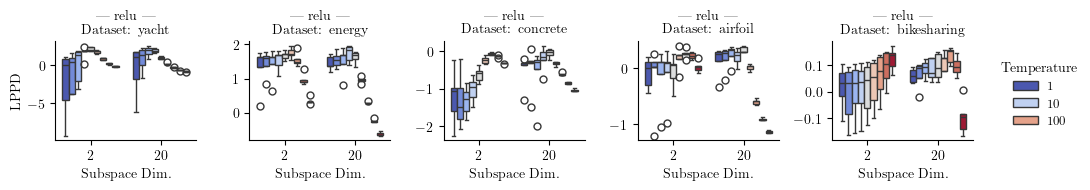

In [33]:
from matplotlib import colors

df_subset = df_clean[df_clean['Space'] == 'lambda']
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], palette='coolwarm', hue_norm=norm)
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
g.set_xlabels('Subspace Dim.')
g.set_ylabels('LPPD')
g.tight_layout()

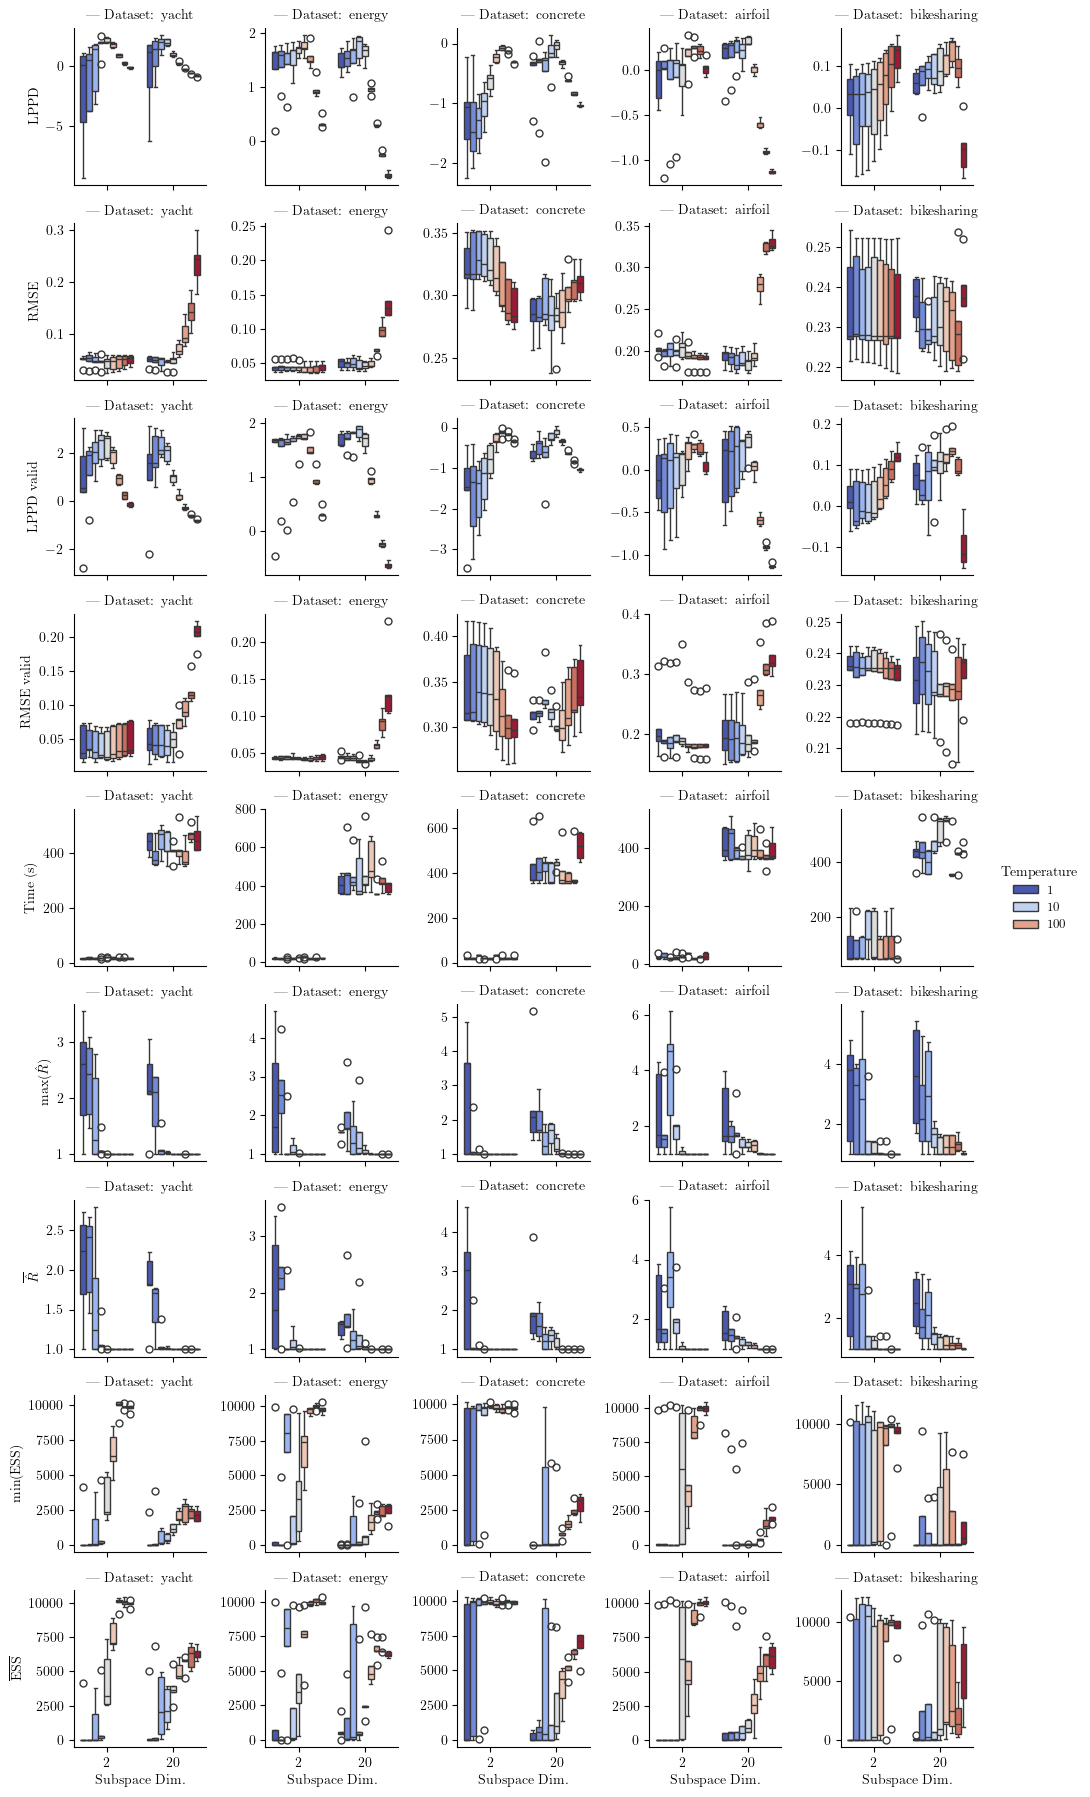

In [37]:
df_subset = df_clean[df_clean['Space'] == 'lambda']
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False).reset_index()

# log color scale
vmin = df_melt['Temperature'].min()
vmax = df_melt['Temperature'].max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# rename rows
rows_order = df_melt['metric'].unique()[:-1]
def rename_fn(x):
    if x == 'lppd_test':
        return 'LPPD'
    elif x == 'rmse_test':
        return 'RMSE'
    elif x == 'lppd_valid':
        return 'LPPD valid'
    elif x == 'rmse_valid':
        return 'RMSE valid'
    elif x == 'time_s':
        return 'Time (s)'
    elif x == 'r_hat_max':
        return r'$\textrm{max}(\hat{R})$'
    elif x == 'r_hat_mean':
        return r'$\overline{\hat{R}}$'
    elif x == 'ess_min':
        return r'$\textrm{min}(\textrm{ESS})$'
    elif x == 'ess_mean':
        return r'$\overline{\textrm{ESS}}$'
    else:
        return x


g = sns.catplot(data=df_melt, y='value', x='SubspaceDim',
                col='Dataset', row='metric', kind='box', hue='Temperature', sharey=False, height=figsize[1], row_order=rows_order, palette='coolwarm', hue_norm=norm)
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
# g.set_titles(row_template='',
#              col_template='Dataset: {col_name} ---')
g.set_xlabels('Subspace Dim.')
for ax, ylabel in zip(g.axes[:, 0], rows_order):
    ax.set_ylabel(rename_fn(ylabel))
g.tight_layout()

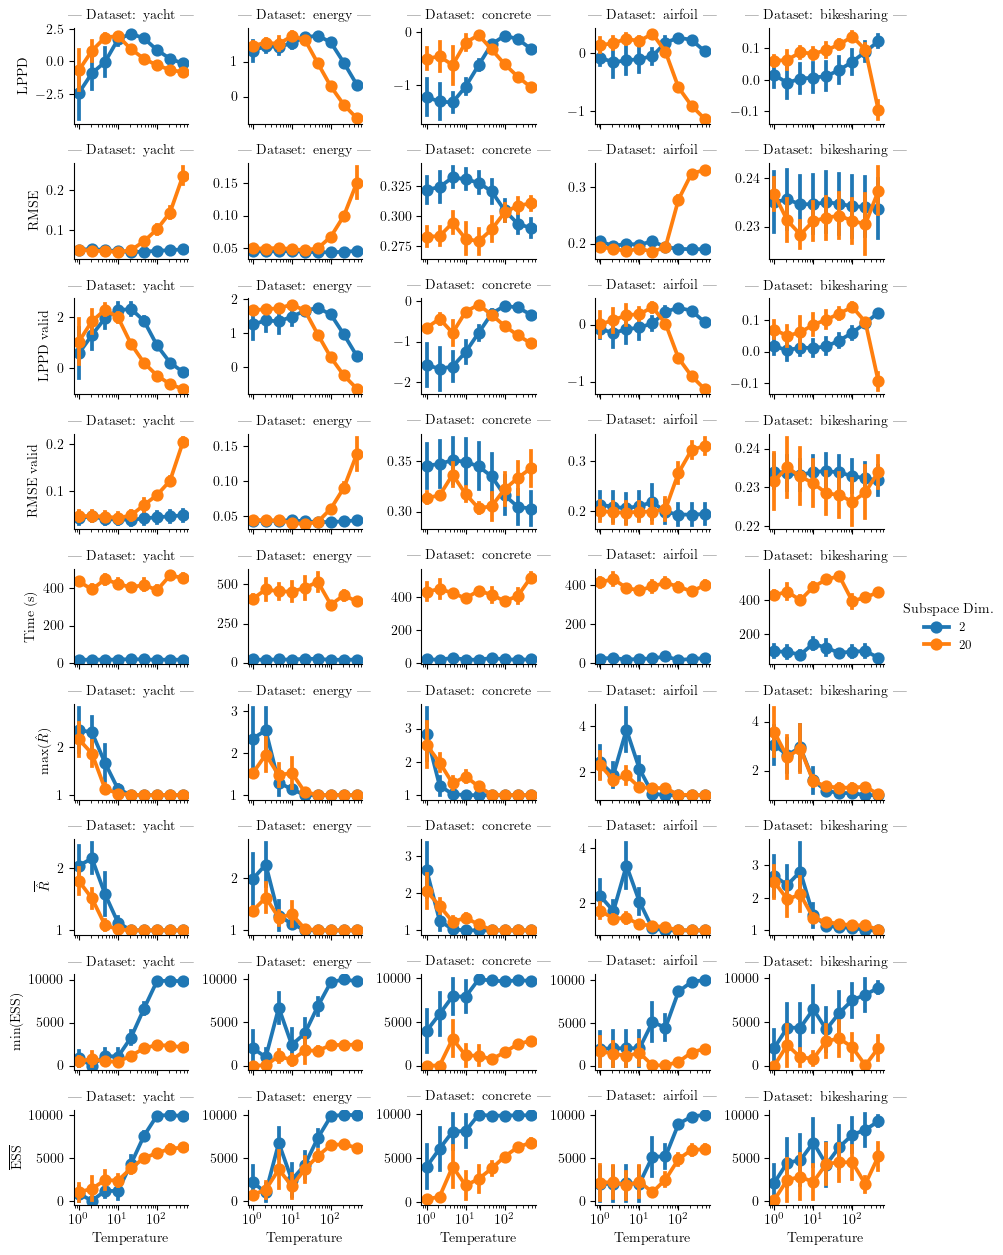

In [53]:
df_subset = df_clean[df_clean['Space'] == 'lambda']
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False).reset_index()

# log color scale
vmin = df_melt['Temperature'].min()
vmax = df_melt['Temperature'].max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# rename rows
rows_order = df_melt['metric'].unique()[:-1]


def rename_fn(x):
    if x == 'lppd_test':
        return 'LPPD'
    elif x == 'rmse_test':
        return 'RMSE'
    elif x == 'lppd_valid':
        return 'LPPD valid'
    elif x == 'rmse_valid':
        return 'RMSE valid'
    elif x == 'time_s':
        return 'Time (s)'
    elif x == 'r_hat_max':
        return r'$\textrm{max}(\hat{R})$'
    elif x == 'r_hat_mean':
        return r'$\overline{\hat{R}}$'
    elif x == 'ess_min':
        return r'$\textrm{min}(\textrm{ESS})$'
    elif x == 'ess_mean':
        return r'$\overline{\textrm{ESS}}$'
    else:
        return x


g = sns.catplot(data=df_melt, y='value', x='Temperature',
                col='Dataset', row='metric', kind='point', hue='SubspaceDim', sharey=False, height=figsize[1]*0.7, row_order=rows_order, palette='tab10', errorbar='se', native_scale=True, aspect=1.3)
g.set_titles(row_template='',
             col_template='Dataset: {col_name} ---')
g.set_xlabels('Temperature')
for ax in g.axes.flatten():
    ax.set_xscale('log')
for ax, ylabel in zip(g.axes[:, 0], rows_order):
    ax.set_ylabel(rename_fn(ylabel))
g.tight_layout()
g.legend.set_title('Subspace Dim.')
plt.savefig("figures/uci_subspace_all_metrics_tunnel.pdf", bbox_inches='tight')

In [17]:
variable_idx

array(['Dataset', 'Space', 'SubspaceDim', 'Temperature'], dtype='<U11')

In [18]:
# with cleaned data
idx_max_lppd_valid = df_clean.groupby(
    ['Activation', 'Space', 'SubspaceDim', 'Dataset', 'Seed'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(
    ['Space', 'Dataset', 'Activation', 'SubspaceDim']).mean()

lppd_test  rmse_test  lppd_valid  \
Space  Dataset     Activation SubspaceDim                                     
lambda airfoil     relu       2             0.254036   0.192453    0.328250   
                              20            0.340047   0.182344    0.340453   
       bikesharing relu       2             0.122994   0.233696    0.125108   
                              20            0.136817   0.230320    0.145650   
       concrete    relu       2            -0.075528   0.302095   -0.113371   
                              20           -0.042895   0.278687   -0.076764   
       energy      relu       2             1.744124   0.042982    1.781792   
                              20            1.700004   0.048247    1.858057   
       yacht       relu       2             0.749388   0.048069    2.394165   
                              20            1.330797   0.044377    2.343724   
line   airfoil     relu       2             0.264615   0.194044    0.327163   
                              20            0.386217   0.175232    0.414543   
       bikesharing relu       2             0.123109   0.233673    0.126329   
                              20            0.197061   0.225533    0.201058   
       concrete    relu       2            -0.071930   0.304719   -0.114214   
                              20            0.060098   0.272080    0.006908   
       energy      relu       2             1.752610   0.043211    1.798151   
                              20            1.831246   0.042746    1.906376   
       yacht       relu       2             0.974965   0.046902    2.333957   
                              20            1.483542   0.046524    2.407629   
varphi airfoil     relu       2             0.268887   0.191914    0.319598   
                              20            0.356075   0.178893    0.406023   
       bikesharing relu       2             0.120324   0.234086    0.123071   
                              20            0.154828   0.229489    0.165185   
       concrete    relu       2            -0.078959   0.302042   -0.119009   
                              20           -0.080765   0.287597   -0.125429   
       energy      relu       2             1.755398   0.042807    1.795224   
                              20            1.787910   0.045236    1.905953   
       yacht       relu       2             1.527852   0.045306    2.401011   
                              20            1.503632   0.048360    2.478155   

                                           rmse_valid      time_s  r_hat_max  \
Space  Dataset     Activation SubspaceDim                                      
lambda airfoil     relu       2              0.194163   24.616914      1.742   
                              20             0.194549  391.590430      1.690   
       bikesharing relu       2              0.231799   65.374418      1.000   
                              20             0.225492  433.826670      1.370   
       concrete    relu       2              0.314113   18.777374      1.000   
                              20             0.306816  422.994852      1.306   
       energy      relu       2              0.041580   23.213803      1.002   
                              20             0.040742  416.243268      1.540   
       yacht       relu       2              0.037848   19.756149      1.504   
                              20             0.044160  434.445899      1.572   
line   airfoil     relu       2              0.196102   20.978869      2.052   
                              20             0.190503  410.853309      1.406   
       bikesharing relu       2              0.231794   97.875052      1.000   
                              20             0.222439  460.957084      1.126   
       concrete    relu       2              0.317221   19.726150      1.000   
                              20             0.300070  445.985819      1.056   
       energy      relu       2              0.041548   22.247979      1.0

In [20]:
# old
idx_max_lppd_valid = df_clean.groupby(['Activation', 'Space', 'SubspaceDim', 'Dataset', 'Seed'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(['Space', 'Dataset', 'Activation', 'SubspaceDim']).mean()

lppd_test  rmse_test  lppd_valid  \
Space  Dataset     Activation SubspaceDim                                     
lambda airfoil     relu       2             0.254036   0.192453    0.328250   
                              20            0.340047   0.182344    0.340453   
       bikesharing relu       2             0.122994   0.233696    0.125108   
                              20            0.133218   0.230459    0.143935   
       concrete    relu       2            -0.075528   0.302095   -0.113371   
                              20           -0.042895   0.278687   -0.076764   
       energy      relu       2             1.744124   0.042982    1.781792   
                              20            1.700004   0.048247    1.858057   
       yacht       relu       2             1.259326   0.048783    2.381145   
                              20            1.330797   0.044377    2.343724   
line   airfoil     relu       2             0.264615   0.194044    0.327163   
                              20            0.386217   0.175232    0.414543   
       bikesharing relu       2             0.123109   0.233673    0.126329   
                              20            0.197061   0.225533    0.201058   
       concrete    relu       2            -0.071930   0.304719   -0.114214   
                              20            0.060098   0.272080    0.006908   
       energy      relu       2             1.752610   0.043211    1.798151   
                              20            1.799516   0.043237    1.894480   
       yacht       relu       2             0.974965   0.046902    2.333957   
                              20            1.483542   0.046524    2.407629   
varphi airfoil     relu       2             0.282671   0.192606    0.318974   
                              20            0.329194   0.187252    0.385587   
       bikesharing relu       2             0.120324   0.234086    0.123071   
                              20           -0.347747   0.376917   -0.346037   
       concrete    relu       2            -0.078959   0.302042   -0.119009   
                              20           -0.144336   0.286631   -0.207544   
       energy      relu       2             1.758793   0.042754    1.793141   
                              20            1.761744   0.046946    1.896545   
       yacht       relu       2             1.997613   0.045332    2.378705   
                              20            1.503632   0.048360    2.478155   

                                           rmse_valid      time_s  r_hat_max  \
Space  Dataset     Activation SubspaceDim                                      
lambda airfoil     relu       2              0.194163   24.616914     1.7420   
                              20             0.194549  391.590430     1.6900   
       bikesharing relu       2              0.231799   65.374418     1.0000   
                              20             0.225743  457.701879     1.3720   
       concrete    relu       2              0.314113   18.777374     1.0000   
                              20             0.306816  422.994852     1.3060   
       energy      relu       2              0.041580   23.213803     1.0020   
                              20             0.040742  416.243268     1.5400   
       yacht       relu       2              0.037859   19.656167     1.4640   
                              20             0.044160  434.445899     1.5720   
line   airfoil     relu       2              0.196102   20.978869     2.0520   
                              20             0.190503  410.853309     1.4060   
       bikesharing relu       2              0.231794   97.875052     1.0000   
                              20             0.222439  460.957084     1.1260   
       concrete    relu       2              0.317221   19.726150     1.0000   
                              20             0.300070  445.985819     1.0560   
       energy      relu       2              0.041548   22.247979     1.00

In [10]:
idx_max_lppd_valid = df_clean.groupby(
    ['Activation', 'Space', 'SubspaceDim', 'Dataset', 'Seed'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(
    ['Space', 'Dataset', 'Activation', 'SubspaceDim']).mean()

lppd_test  rmse_test  lppd_valid  \
Space  Dataset     Activation SubspaceDim                                     
lambda airfoil     relu       2             0.254036   0.192453    0.328250   
                              20            0.340047   0.182344    0.340453   
       bikesharing relu       2             0.122994   0.233696    0.125108   
                              20            0.133218   0.230459    0.143935   
       concrete    relu       2            -0.075528   0.302095   -0.113371   
                              20           -0.042895   0.278687   -0.076764   
       energy      relu       2             1.744124   0.042982    1.781792   
                              20            1.700004   0.048247    1.858057   
       yacht       relu       2             1.259326   0.048783    2.381145   
                              20            1.330797   0.044377    2.343724   
line   airfoil     relu       2             0.264615   0.194044    0.327163   
                              20            0.386217   0.175232    0.414543   
       bikesharing relu       2             0.123109   0.233673    0.126329   
                              20            0.197061   0.225533    0.201058   
       concrete    relu       2            -0.071930   0.304719   -0.114214   
                              20            0.060098   0.272080    0.006908   
       energy      relu       2             1.752610   0.043211    1.798151   
                              20            1.831246   0.042746    1.906376   
       yacht       relu       2             0.974965   0.046902    2.333957   
                              20            1.483542   0.046524    2.407629   
varphi airfoil     relu       2             0.282671   0.192606    0.318974   
                              20            0.356075   0.178893    0.406023   
       bikesharing relu       2             0.120324   0.234086    0.123071   
                              20           -0.347747   0.376917   -0.346037   
       concrete    relu       2            -0.078959   0.302042   -0.119009   
                              20           -0.080765   0.287597   -0.125429   
       energy      relu       2             1.758793   0.042754    1.793141   
                              20            1.787910   0.045236    1.905953   
       yacht       relu       2             1.997613   0.045332    2.378705   
                              20            1.503632   0.048360    2.478155   

                                           rmse_valid      time_s  r_hat_max  \
Space  Dataset     Activation SubspaceDim                                      
lambda airfoil     relu       2              0.194163   24.616914     1.7420   
                              20             0.194549  391.590430     1.6900   
       bikesharing relu       2              0.231799   65.374418     1.0000   
                              20             0.225743  457.701879     1.3720   
       concrete    relu       2              0.314113   18.777374     1.0000   
                              20             0.306816  422.994852     1.3060   
       energy      relu       2              0.041580   23.213803     1.0020   
                              20             0.040742  416.243268     1.5400   
       yacht       relu       2              0.037859   19.656167     1.4640   
                              20             0.044160  434.445899     1.5720   
line   airfoil     relu       2              0.196102   20.978869     2.0520   
                              20             0.190503  410.853309     1.4060   
       bikesharing relu       2              0.231794   97.875052     1.0000   
                              20             0.222439  460.957084     1.1260   
       concrete    relu       2              0.317221   19.726150     1.0000   
                              20             0.300070  445.985819     1.0560   
       energy      relu       2              0.041548   22.247979     1.00

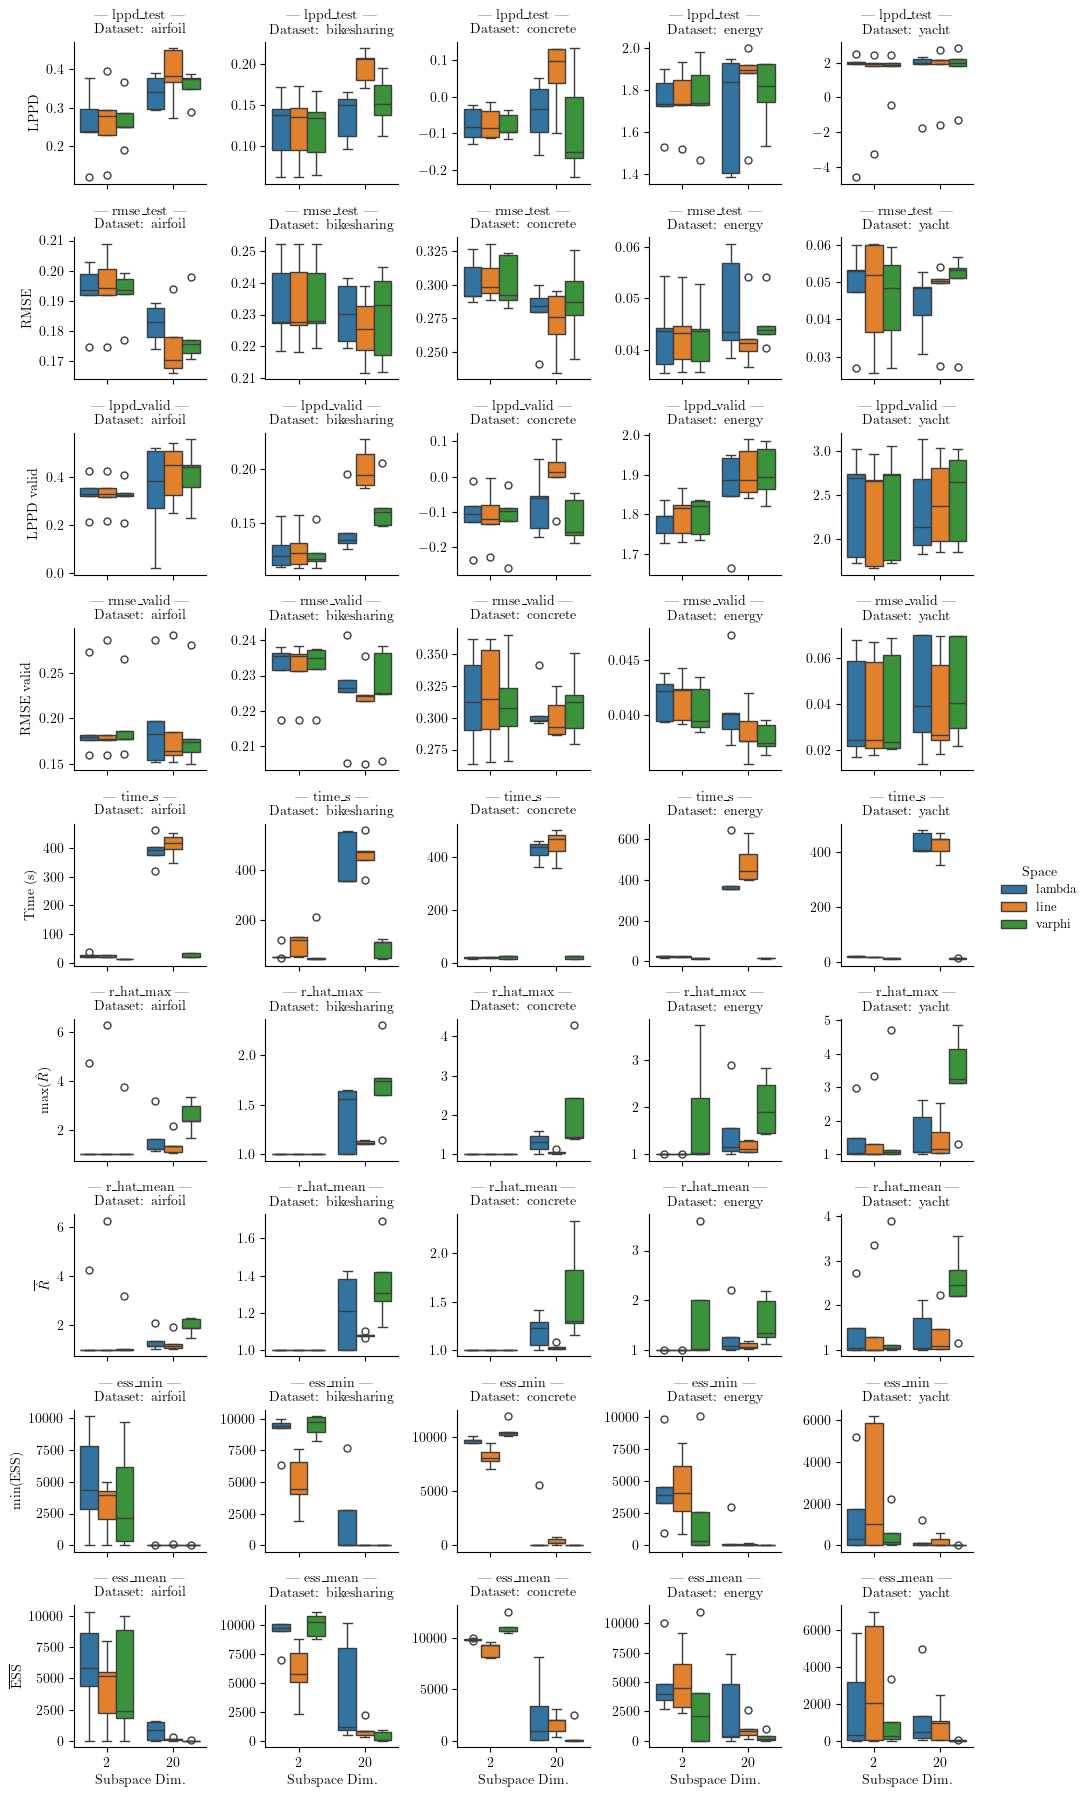

In [27]:
df_subset = df_best_t[df_best_t['Space'] == 'lambda']
df_subset = df_best_t
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)
rows_order = df_melt['metric'].unique()[:-1]
def rename_fn(x):
    if x == 'lppd_test':
        return 'LPPD'
    elif x == 'rmse_test':
        return 'RMSE'
    elif x == 'lppd_valid':
        return 'LPPD valid'
    elif x == 'rmse_valid':
        return 'RMSE valid'
    elif x == 'time_s':
        return 'Time (s)'
    elif x == 'r_hat_max':
        return r'$\textrm{max}(\hat{R})$'
    elif x == 'r_hat_mean':
        return r'$\overline{\hat{R}}$'
    elif x == 'ess_min':
        return r'$\textrm{min}(\textrm{ESS})$'
    elif x == 'ess_mean':
        return r'$\overline{\textrm{ESS}}$'
    else:
        return x

g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
                col='Dataset', row='metric', kind='box', hue='Space', sharey=False, height=figsize[1], row_order=rows_order)
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
g.set_xlabels('Subspace Dim.')
for ax, ylabel in zip(g.axes[:,0], rows_order):
    ax.set_ylabel(rename_fn(ylabel))
g.tight_layout()

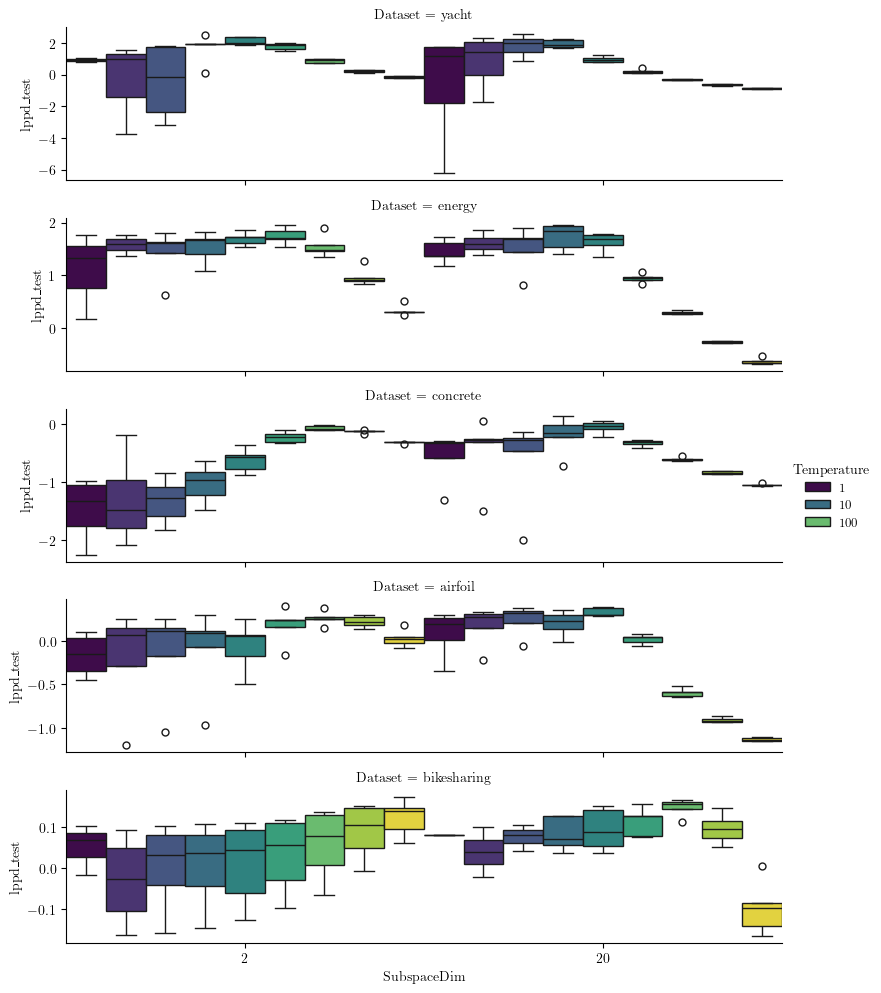

In [23]:
from matplotlib import colors

df_best_t_sub = df_best_t[(df_best_t['Activation'] == 'relu')
                         & (df_best_t['Space'] == 'lambda')]
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                row='Dataset', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))

# g.map_dataframe(sns.boxplot, data=df_best_t_sub, y='lppd_test', x='SubspaceDim', width=.1, color='red')
# g.axes[0, 0].set_ylim(-5, )
# Add the new plot to the existing FacetGrid
# for ax in g.axes.flat:
#     sns.boxplot(data=df_best_t_sub, y='lppd_test',
#                 x='SubspaceDim', ax=ax, color='red', width=.1)
#     ax.set_ylabel('lppd_test')  # Ensure the y-axis label is consistent

g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

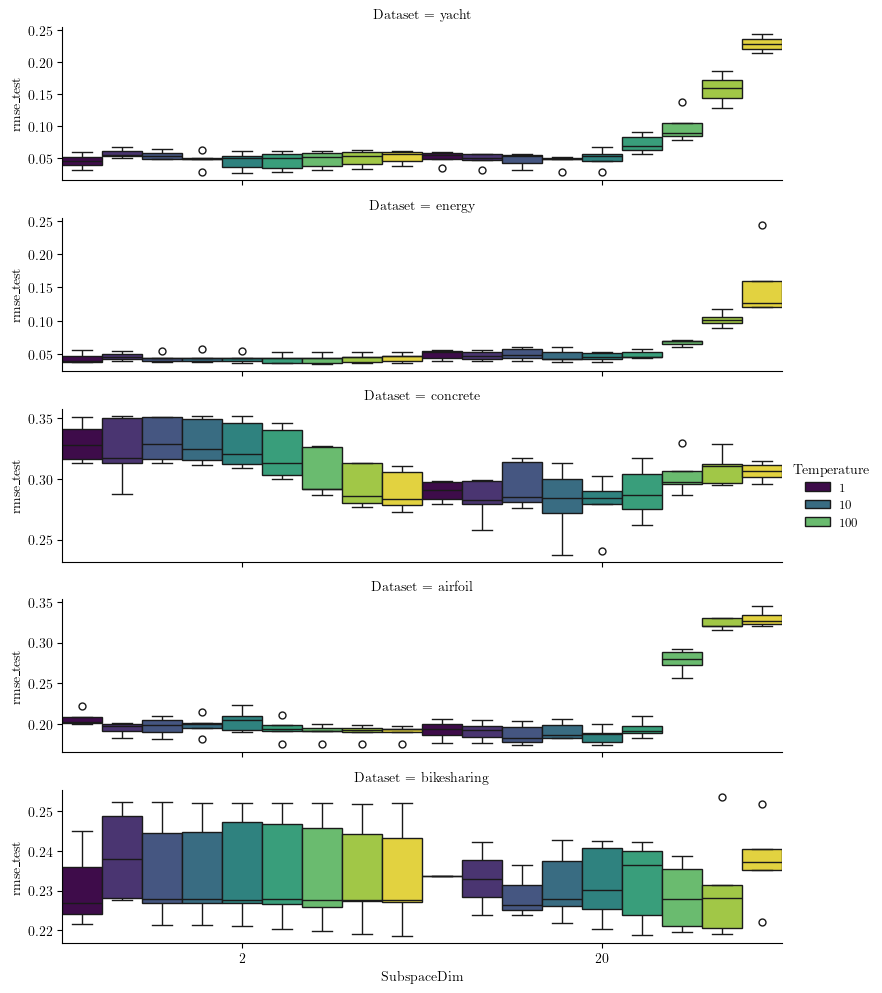

In [24]:
from matplotlib import colors
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                row='Dataset', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# g.axes[0, 0].set_ylim(-5, )
g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

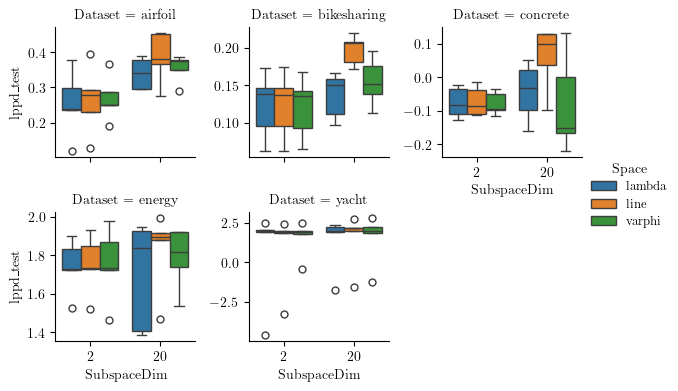

In [33]:
#cleaned data
# df_subset = df_best_t
df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Space', sharey=False, height=figsize[1], legend=True, col_wrap=3,)  # errorbar='se')
# g.axes[0, 0].set_ylim(-5, )
g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

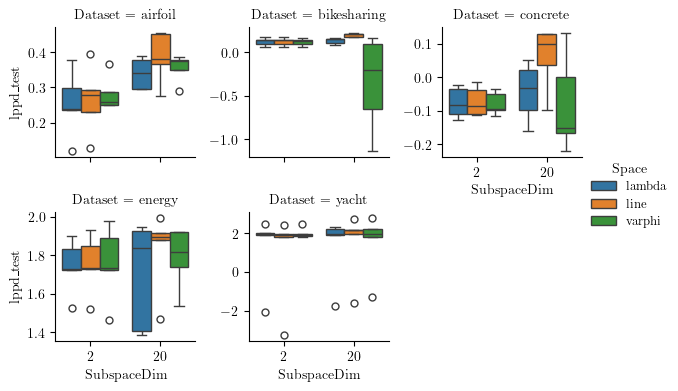

In [11]:
# df_subset = df_best_t
df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Space', sharey=False, height=figsize[1], legend=True, col_wrap=3,)# errorbar='se')
# g.axes[0, 0].set_ylim(-5, )
g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

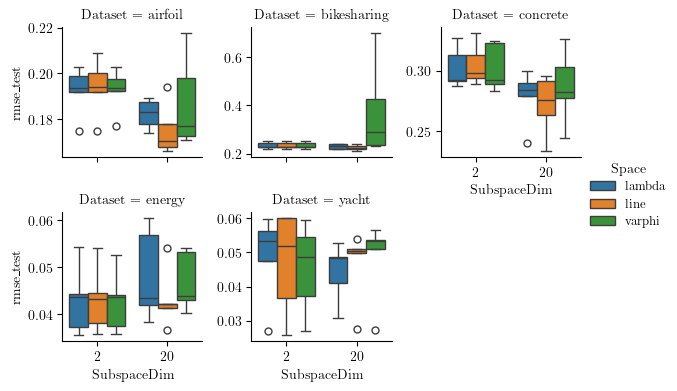

In [30]:
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Space', sharey=False, height=figsize[1], legend=True, col_wrap=3)

g.savefig('figures/uci_best_t_rmse_test.pdf', bbox_inches='tight')

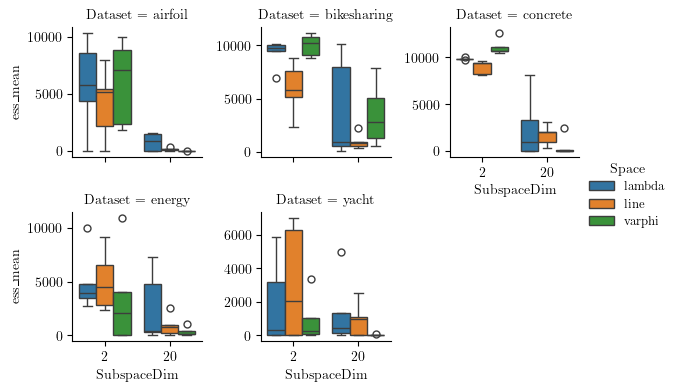

In [36]:
g = sns.catplot(data=df_subset, y='ess_mean', x='SubspaceDim',
                col='Dataset', kind='box', hue='Space', sharey=False, height=figsize[1], legend=True, col_wrap=3)

# g.savefig('figures/uci_best_t_rmse_test.pdf', bbox_inches='tight')

In [39]:
# cleaned data
# best t
df_subset = df_best_t[(df_best_t['Activation'] == 'relu')]
# # or select temperature
# df_subset = df_clean[(df_clean['Activation'] == 'relu') & (df_clean['Temperature'] == 1.)]

df_subset = df_subset.loc[:, ['Dataset', 'Space',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'Space', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['rmse_test_std'].round(2).apply(lambda y: f"{y:.2f}"),
    lppd_test=lambda x: x['lppd_test_mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['lppd_test_std'].round(2).apply(lambda y: f"{y:.2f}")
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])  # [['lppd_test',]]

rmse_test     lppd_test
Dataset     Space  SubspaceDim                           
airfoil     lambda 2            0.19 ± 0.01   0.25 ± 0.09
                   20           0.18 ± 0.01   0.34 ± 0.04
            line   2            0.19 ± 0.01   0.26 ± 0.10
                   20           0.18 ± 0.01   0.39 ± 0.07
            varphi 2            0.19 ± 0.01   0.27 ± 0.06
                   20           0.18 ± 0.01   0.36 ± 0.04
bikesharing lambda 2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01   0.14 ± 0.03
            line   2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01   0.20 ± 0.02
            varphi 2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01   0.15 ± 0.03
concrete    lambda 2            0.30 ± 0.02  -0.08 ± 0.05
                   20           0.28 ± 0.02  -0.04 ± 0.09
            line   2            0.30 ± 0.02  -0.07 ± 0.04
                   20           0.27 ± 0.02   0.06 ± 0.10
            varphi 2            0.30 ± 0.02  -0.08 ± 0.03
                   20           0.29 ± 0.03  -0.08 ± 0.14
energy      lambda 2            0.04 ± 0.01   1.74 ± 0.14
                   20           0.05 ± 0.01   1.70 ± 0.28
            line   2            0.04 ± 0.01   1.75 ± 0.16
                   20           0.04 ± 0.01   1.83 ± 0.21
            varphi 2            0.04 ± 0.01   1.76 ± 0.19
                   20           0.05 ± 0.01   1.79 ± 0.16
yacht       lambda 2            0.05 ± 0.01   0.75 ± 3.01
                   20           0.04 ± 0.01   1.33 ± 1.75
            line   2            0.05 ± 0.02   0.97 ± 2.39
                   20           0.05 ± 0.01   1.48 ± 1.75
            varphi 2            0.05 ± 0.01   1.53 ± 1.14
                   20           0.05 ± 0.01   1.50 ± 1.61

In [22]:
# best t
df_subset = df_best_t[(df_best_t['Activation'] == 'relu')]
# or select temperature
# df_subset = df_clean[(df_clean['Activation'] == 'relu') & (df_clean['Temperature'] == 1.)]

df_subset = df_subset.loc[:, ['Dataset', 'Space',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'Space', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['rmse_test_std'].round(2).apply(lambda y: f"{y:.2f}"),
    lppd_test=lambda x: x['lppd_test_mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['lppd_test_std'].round(2).apply(lambda y: f"{y:.2f}")
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])#[['lppd_test',]]

rmse_test     lppd_test
Dataset     Space  SubspaceDim                           
airfoil     lambda 2            0.19 ± 0.01   0.25 ± 0.09
                   20           0.18 ± 0.01   0.34 ± 0.04
            line   2            0.19 ± 0.01   0.26 ± 0.10
                   20           0.18 ± 0.01   0.39 ± 0.07
            varphi 2            0.19 ± 0.01   0.28 ± 0.05
                   20           0.18 ± 0.01   0.36 ± 0.04
bikesharing lambda 2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01   0.13 ± 0.04
            line   2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01   0.20 ± 0.02
            varphi 2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.38 ± 0.22  -0.35 ± 0.60
concrete    lambda 2            0.30 ± 0.02  -0.08 ± 0.05
                   20           0.28 ± 0.02  -0.04 ± 0.09
            line   2            0.30 ± 0.02  -0.07 ± 0.04
                   20           0.27 ± 0.02   0.06 ± 0.10
            varphi 2            0.30 ± 0.02  -0.08 ± 0.03
                   20           0.29 ± 0.03  -0.08 ± 0.14
energy      lambda 2            0.04 ± 0.01   1.74 ± 0.14
                   20           0.05 ± 0.01   1.70 ± 0.28
            line   2            0.04 ± 0.01   1.75 ± 0.16
                   20           0.04 ± 0.01   1.83 ± 0.21
            varphi 2            0.04 ± 0.01   1.76 ± 0.20
                   20           0.05 ± 0.01   1.79 ± 0.16
yacht       lambda 2            0.05 ± 0.01   1.26 ± 1.88
                   20           0.04 ± 0.01   1.33 ± 1.75
            line   2            0.05 ± 0.02   0.97 ± 2.39
                   20           0.05 ± 0.01   1.48 ± 1.75
            varphi 2            0.05 ± 0.01   2.00 ± 0.26
                   20           0.05 ± 0.01   1.50 ± 1.61

In [19]:
df_subset.groupby(['Dataset', 'Space', 'SubspaceDim']).describe()

rmse_test                                \
                                   count      mean       std       min   
Dataset     Space  SubspaceDim                                           
airfoil     lambda 2                 4.0  0.206444  0.010007  0.200146   
                   20                5.0  0.193474  0.011083  0.176712   
            line   2                 4.0  0.194107  0.008471  0.182369   
                   20                5.0  0.194036  0.010473  0.179997   
            varphi 2                 4.0  0.193184  0.009773  0.179968   
                   20                5.0  0.193858  0.015400  0.178145   
bikesharing lambda 2                 3.0  0.231089  0.012308  0.221446   
                   20                1.0  0.233652       NaN  0.233652   
            line   2                 4.0  0.237768  0.013629  0.221435   
                   20                5.0  0.232584  0.007613  0.225379   
            varphi 2                 4.0  0.230970  0.012167  0.218858   
concrete    lambda 2                 4.0  0.329926  0.017601  0.313515   
                   20                5.0  0.283086  0.017137  0.255856   
            line   2                 4.0  0.332827  0.021466  0.312378   
                   20                5.0  0.292154  0.010880  0.280078   
            varphi 2                 3.0  0.304150  0.020218  0.290127   
                   20                5.0  0.289851  0.028568  0.255136   
energy      lambda 2                 3.0  0.044466  0.009772  0.037582   
                   20                5.0  0.049535  0.007135  0.040151   
            line   2                 5.0  0.045703  0.006520  0.037570   
                   20                5.0  0.048387  0.007403  0.038636   
            varphi 2                 4.0  0.044727  0.006260  0.037562   
                   20                5.0  0.046666  0.006629  0.037771   
yacht       lambda 2                 2.0  0.044883  0.018939  0.031491   
                   20                5.0  0.050627  0.009865  0.034462   
            line   2                 4.0  0.051933  0.013881  0.031173   
                   20                5.0  0.050219  0.013418  0.027618   
            varphi 2                 5.0  0.047303  0.013199  0.032484   
                   20                5.0  0.045382  0.011445  0.027201   

                                                                        \
                                     25%       50%       75%       max   
Dataset     Space  SubspaceDim                                           
airfoil     lambda 2            0.200647  0.202169  0.207966  0.221294   
                   20           0.189057  0.197209  0.198675  0.205716   
            line   2            0.190795  0.196380  0.199692  0.201299   
                   20           0.186517  0.197583  0.200768  0.205316   
            varphi 2            0.190651  0.194607  0.197141  0.203553   
                   20           0.182313  0.195436  0.195826  0.217568   
bikesharing lambda 2            0.224158  0.226871  0.235911  0.244951   
                   20           0.233652  0.233652  0.233652  0.233652   
            line   2            0.229656  0.238702  0.246813  0.252234   
                   20           0.226719  0.229692  0.238352  0.242777   
            varphi 2            0.225658  0.228584  0.233897  0.247856   
concrete    lambda 2            0.316338  0.327747  0.341336  0.350695   
                   20           0.279464  0.285109  0.297032  0.297969   
            line   2            0.315245  0.333556  0.351139  0.351818   
                   20           0.283631  0.290653  0.301134  0.305275   
            varphi 2            0.292562  0.294998  0.311162  0.327326   
                   20           0.277609  0.287430  0.296040  0.333041   
energy      lambda 2            0.038874  0.040166  0.047909  0.055651   
                   20           0.043786  0.052576  0.055320  0.055843   
            line   2            0.

In [31]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu')]
df_subset = df_subset.loc[:, ['Dataset', 'Space',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'Space', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['rmse_test_std'].round(2).apply(lambda y: f"{y:.2f}"),
    lppd_test=lambda x: x['lppd_test_mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['lppd_test_std'].round(2).apply(lambda y: f"{y:.2f}")
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])

rmse_test     lppd_test
Dataset     Space  SubspaceDim                           
airfoil     lambda 2            0.19 ± 0.01   0.25 ± 0.09
                   20           0.18 ± 0.01   0.34 ± 0.04
            line   2            0.19 ± 0.01    0.26 ± 0.1
                   20           0.18 ± 0.01   0.39 ± 0.07
            varphi 2            0.19 ± 0.01   0.28 ± 0.05
                   20           0.19 ± 0.02   0.33 ± 0.07
bikesharing lambda 2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01   0.13 ± 0.04
            line   2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.23 ± 0.01    0.2 ± 0.02
            varphi 2            0.23 ± 0.01   0.12 ± 0.04
                   20           0.38 ± 0.22   -0.35 ± 0.6
concrete    lambda 2             0.3 ± 0.02  -0.08 ± 0.05
                   20           0.28 ± 0.02  -0.04 ± 0.09
            line   2             0.3 ± 0.02  -0.07 ± 0.04
                   20           0.27 ± 0.02    0.06 ± 0.1
            varphi 2             0.3 ± 0.02  -0.08 ± 0.03
                   20           0.29 ± 0.03  -0.14 ± 0.17
energy      lambda 2            0.04 ± 0.01   1.74 ± 0.14
                   20           0.05 ± 0.01    1.7 ± 0.28
            line   2            0.04 ± 0.01   1.75 ± 0.16
                   20           0.04 ± 0.01    1.8 ± 0.21
            varphi 2            0.04 ± 0.01    1.76 ± 0.2
                   20           0.05 ± 0.01   1.76 ± 0.16
yacht       lambda 2            0.05 ± 0.01   1.26 ± 1.88
                   20           0.04 ± 0.01   1.33 ± 1.75
            line   2            0.05 ± 0.02   0.97 ± 2.39
                   20           0.05 ± 0.01   1.48 ± 1.75
            varphi 2            0.05 ± 0.01    2.0 ± 0.26
                   20           0.05 ± 0.01    1.5 ± 1.61

In [ ]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu')]
df_subset = df_subset.loc[:, ['Dataset',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(3).astype(
        str) + " ± " + x['rmse_test_std'].round(3).astype(str),
    lppd_test=lambda x: x['lppd_test_mean'].round(3).astype(
        str) + " ± " + x['lppd_test_std'].round(3).astype(str)
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])

rmse_test       lppd_test
Dataset     SubspaceDim                               
airfoil     2            0.228 ± 0.013   0.014 ± 0.162
            7            0.213 ± 0.016   0.195 ± 0.056
            10           0.211 ± 0.016   0.167 ± 0.075
            20           0.218 ± 0.018   0.121 ± 0.143
            40             0.215 ± nan     0.155 ± nan
bikesharing 2            0.246 ± 0.018   0.091 ± 0.036
            7            0.242 ± 0.012    0.11 ± 0.048
            10            0.237 ± 0.01   0.096 ± 0.047
            20           0.239 ± 0.006     0.08 ± 0.03
            40             0.261 ± nan    -0.016 ± nan
concrete    2            0.353 ± 0.024  -0.296 ± 0.041
            7            0.297 ± 0.018  -0.157 ± 0.099
            10           0.312 ± 0.013  -0.172 ± 0.055
            20           0.291 ± 0.017  -0.113 ± 0.033
energy      2            0.046 ± 0.004   1.678 ± 0.064
            7             0.05 ± 0.008   1.485 ± 0.307
            10           0.048 ± 0.002   1.616 ± 0.039
            20           0.053 ± 0.006   1.511 ± 0.128
yacht       2             0.054 ± 0.01   0.938 ± 0.598
            7            0.052 ± 0.016   1.607 ± 0.868
            10           0.051 ± 0.013   1.626 ± 0.346
            20           0.053 ± 0.013    1.45 ± 0.396

#### with specific temperature

### analyse wandb runs

In [3]:
api = wandb.Api()
results = []
# for s_id in ['4upb68ur',]:
for s_id in ['dpu3133r', 'cynw31l3']:
    t_bar = tqdm(api.sweep(f"ddold/subspace_experiments/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if ((run.state == 'finished') or (run.state == 'crashed')):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Sampler=run.config['sampling']['sampler'],
                       Space=run.config['sampling']['space_config']['space'],
                       PriorScale=run.config['sampling']['space_config'].get('prior_scale', -1),
                       TubeScale=run.config['sampling']['space_config'].get(
                           'tube_scale', -1),
                       Epsilon=run.config['sampling']['space_config'].get(
                           'epsilon', -1),
                       Temperature=run.config['sampling']['temperature'],
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       PriorCorrection="all" if run.config['sampling']['space_config'].get(
                           'prior_correct', False) else "only t",
                       Dataset=run.config['dataset'],
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                    #    elpd_loo=run.summary.get('elpd_loo', -np.inf),
                       lppd_test=run.summary.get('elpd_test', np.nan),
                       rmse_test=run.summary.get('rmse_test', np.nan),
                       lppd_valid=run.summary.get('elpd_valid', np.nan),
                       rmse_valid=run.summary.get('rmse_valid', np.nan),
                    #    p_loo=run.summary.get('p_loo', -np.inf),
                       time_s=run.summary.get('time_s', np.nan),
                       r_hat_max=run.summary.get('r_hat_max', np.nan),
                       r_hat_mean=run.summary.get('r_hat_mean', np.nan),
                       ess_min=run.summary.get('ess_min', np.nan),
                       ess_mean=run.summary.get('ess_mean', np.nan),
                       num_forward=run.summary.get('num_forward', np.nan),
                       )
            results.append(res)
        else:
            print(f"Encoundert problem with run {run.name}; state: {run.state}")

df = pd.DataFrame(results)
df

Sweep id: dpu3133r:   0%|          | 0/2034 [00:00<?, ?it/s, royal-sweep-2023]    

Sweep id: dpu3133r:  14%|█▍        | 281/2034 [00:00<00:05, 345.97it/s, dazzling-sweep-1724]     

Encoundert problem with run still-sweep-1792; state: failed


Sweep id: cynw31l3:   6%|▌         | 51/824 [00:00<00:01, 440.25it/s, wobbly-sweep-735]   

Encoundert problem with run rosy-sweep-824; state: running
Encoundert problem with run eager-sweep-823; state: running
Encoundert problem with run classic-sweep-822; state: running
Encoundert problem with run autumn-sweep-821; state: running
Encoundert problem with run logical-sweep-820; state: running


Sweep id: cynw31l3: 100%|██████████| 824/824 [00:02<00:00, 375.59it/s, playful-sweep-1]        


,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,rmse_test,lppd_valid,rmse_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
0,nwn7uiz0,nuts,lambda,0.5,0.1,25,464.159,relu,40,2,...,-0.199811,0.248228,-0.219335,0.261096,3801.848052,1.04,1.00625,207.0,3897.325,116.926407
1,stzytaf0,nuts,lambda,0.5,0.1,25,215.443,relu,40,2,...,-0.048035,0.247581,-0.071875,0.251173,5054.165278,1.01,1.00125,643.0,3271.825,254.546310
2,wyrekg56,nuts,lambda,0.5,0.1,25,100.000,relu,40,2,...,0.110023,0.243023,0.072188,0.249666,6167.329069,1.07,1.01450,117.0,1279.400,254.972214
3,96so6ukb,nuts,lambda,0.5,0.1,25,46.416,relu,40,2,...,0.075392,0.243143,0.011835,0.252974,2595.014034,1.01,1.00050,1191.0,6211.025,93.179207
4,b4wg832a,nuts,lambda,0.5,0.1,25,21.544,relu,40,2,...,0.064402,0.244023,0.014815,0.248376,2448.273157,1.42,1.11700,20.0,1685.775,76.563202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,j0cnh80w,nuts,line,-1.0,-1.0,25,21.544,relu,2,0,...,-0.099635,0.258615,0.021929,0.236398,312.036536,1.00,1.00000,6657.0,8092.500,99.075203
2848,7kzehhmj,nuts,line,-1.0,-1.0,25,10.000,relu,2,0,...,-0.164798,0.253821,-0.107580,0.245885,600.667340,1.00,1.00000,9105.0,9126.500,91.079002
2849,j012f7ix,nuts,line,-1.0,-1.0,25,4.642,relu,2,0,...,-0.174879,0.253821,-0.117550,0.245916,554.118413,1.00,1.00000,8445.0,8445.000,75.666405
2850,ek51dggr,nuts,line,-1.0,-1.0,25,2.154,relu,2,0,...,-0.151220,0.254202,-0.016959,0.233866,306.391414,1.01,1.01000,1065.0,1065.000,81.311401


In [4]:
# get all colum names that starts with capital letter
cols = [col for col in df.columns if col[0].isupper()]
cols

['Id',
 'Sampler',
 'Space',
 'PriorScale',
 'TubeScale',
 'Epsilon',
 'Temperature',
 'Activation',
 'SubspaceDim',
 'Seed',
 'PriorCorrection',
 'Dataset',
 'SelectFromValidation']

In [5]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,Id,Sampler,Space,PriorScale,TubeScale,Epsilon,Temperature,Activation,SubspaceDim,Seed,...,lppd_test,rmse_test,lppd_valid,rmse_valid,time_s,r_hat_max,r_hat_mean,ess_min,ess_mean,num_forward
21,6ga0qr86,nuts,lambda,0.5,0.1,25,1000.0,elu,20,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
variable_idx = []
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        unique_ = df_clean[c].unique()
        print(c, unique_)
        if (len(unique_) > 1) and( c != 'Seed'):
            variable_idx.append(c)
print(f"\nExperiment differs in {variable_idx} configs")

Unique configuartions: 
Sampler ['nuts']
Space ['lambda' 'line']
PriorScale [ 0.5 -1. ]
TubeScale [ 0.1 -1. ]
Epsilon [25]
Temperature [ 464.159  215.443  100.      46.416   21.544   10.       4.642    2.154
    1.    1000.   ]
Activation ['relu' 'elu']
SubspaceDim [40 20 10  7  2]
Seed [2 1 4 3 0]
PriorCorrection ['only t']
Dataset ['bikesharing' 'energy' 'concrete' 'airfoil' 'yacht']
SelectFromValidation [ True]

Experiment differs in ['Space', 'PriorScale', 'TubeScale', 'Temperature', 'Activation', 'SubspaceDim', 'Dataset'] configs


In [7]:
df_clean.set_index(idx_ids).groupby(variable_idx).mean()

lppd_test  \
Space  PriorScale TubeScale Temperature Activation SubspaceDim Dataset                  
lambda  0.5        0.1      1.0         elu        2           airfoil      -1.803159   
                                                               bikesharing  -0.050123   
                                                               concrete     -1.651527   
                                                               energy        1.405959   
                                                               yacht         0.090631   
...                                                                               ...   
line   -1.0       -1.0      1000.0      relu       10          concrete     -0.603119   
                                                               energy       -0.119357   
                                                               yacht        -0.408702   
                                                   20          airfoil      -0.259828   
                                                               bikesharing   0.100234   

                                                                            rmse_test  \
Space  PriorScale TubeScale Temperature Activation SubspaceDim Dataset                  
lambda  0.5        0.1      1.0         elu        2           airfoil       0.210104   
                                                               bikesharing   0.237700   
                                                               concrete      0.344275   
                                                               energy        0.047392   
                                                               yacht         0.041948   
...                                                                               ...   
line   -1.0       -1.0      1000.0      relu       10          concrete      0.317282   
                                                               energy        0.145260   
                                                               yacht         0.293615   
                                                   20          airfoil       0.204387   
                                                               bikesharing   0.234908   

                                                                            lppd_valid  \
Space  PriorScale TubeScale Temperature Activation SubspaceDim Dataset                   
lambda  0.5        0.1      1.0         elu        2           airfoil       -0.641565   
                                                               bikesharing    0.002774   
                                                               concrete      -1.095606   
                                                               energy         1.647633   
                                                               yacht          1.418275   
...                                                                                ...   
line   -1.0       -1.0      1000.0      relu       10          concrete      -0.620610   
                                                               energy        -0.112963   
                                                               yacht         -0.393659   
                                                   20          airfoil       -0.222943   
                                                               bikesharing    0.104228   

                                                                            rmse_valid  \
Space  PriorScale TubeScale Temperature Activation SubspaceDim Dataset                   
lambda  0.5        0.1      1.0         elu        2           airfoil        0.175972   
                                                               bikesharing    0.229262   
                                                               concrete       0.314655   
                                                               energy         0.041413   
                                                 

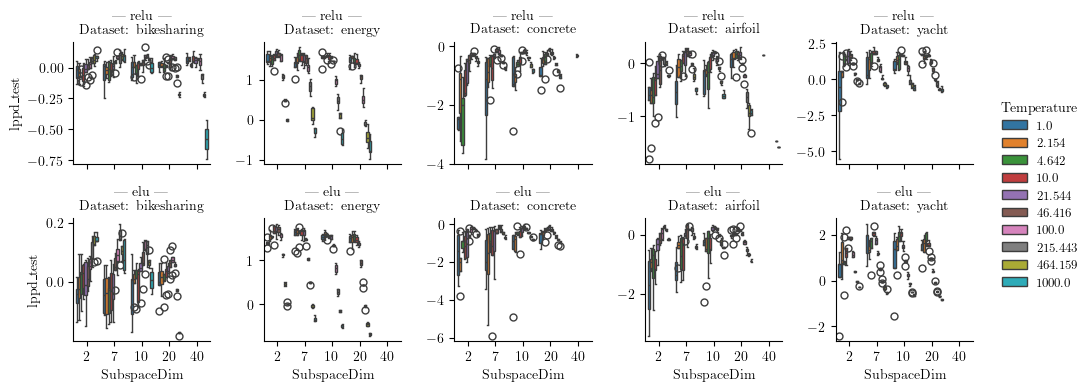

In [8]:
df_subset = df_clean[df_clean['Space'] == 'lambda']
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', row='Activation', kind='box', hue='Temperature', sharey=False, height=figsize[1], palette='tab10')
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
g.tight_layout()

In [9]:
variable_idx

['Space',
 'PriorScale',
 'TubeScale',
 'Temperature',
 'Activation',
 'SubspaceDim',
 'Dataset']

In [10]:
idx_max_lppd_valid = df_clean.groupby(['Activation', 'Space', 'SubspaceDim', 'Dataset', 'Seed'])['lppd_valid'].idxmax()
df_best_t = df_clean.loc[idx_max_lppd_valid]
df_best_t.set_index(idx_ids).groupby(['Space', 'Dataset', 'Activation', 'SubspaceDim']).mean()

lppd_test  rmse_test  lppd_valid  \
Space  Dataset     Activation SubspaceDim                                     
lambda airfoil     elu        2             0.203856   0.198405    0.455555   
                              7             0.269078   0.202433    0.409334   
                              10            0.199236   0.210532    0.383137   
                              20            0.170086   0.206634    0.287537   
                   relu       2             0.014309   0.228044    0.274576   
                              7             0.195014   0.213220    0.343743   
                              10            0.167113   0.210535    0.304693   
                              20            0.121163   0.217890    0.237933   
                              40           -0.961976   0.557898   -0.890623   
       bikesharing elu        2             0.127564   0.232682    0.139918   
                              7             0.147211   0.234475    0.165453   
                              10            0.108781   0.233879    0.117323   
                              20            0.073697   0.237418    0.076145   
                   relu       2             0.090587   0.245723    0.104221   
                              7             0.109881   0.242464    0.132670   
                              10            0.096128   0.237315    0.105892   
                              20            0.080012   0.239243    0.117997   
                              40            0.100542   0.235592    0.096761   
       concrete    elu        2            -0.287439   0.335017   -0.126934   
                              7            -0.139668   0.298908   -0.141844   
                              10           -0.115112   0.297904   -0.097797   
                              20           -0.166371   0.302422   -0.179170   
                   relu       2            -0.296060   0.353313   -0.215320   
                              7            -0.156782   0.297097   -0.131502   
                              10           -0.171585   0.312103   -0.099197   
                              20           -0.112870   0.290654   -0.132836   
                              40           -0.323162   0.335718   -0.316509   
       energy      elu        2             1.696460   0.043789    1.899751   
                              7             1.617357   0.048239    1.698912   
                              10            1.596103   0.049324    1.695147   
                              20            1.538854   0.051350    1.645761   
                   relu       2             1.677907   0.045830    1.863131   
                              7             1.485285   0.050287    1.821402   
                              10            1.615856   0.048248    1.764218   
                              20            1.510676   0.053264    1.662258   
       yacht       elu        2             1.554164   0.043555    2.433268   
                              7             2.044201   0.038543    2.318609   
                              10            1.886991   0.040600    2.201387   
                              20            1.753901   0.046061    2.011619   
                   relu       2             0.938313   0.054168    2.385608   
                              7             1.606678   0.052268    2.211126   
                              10            1.626304   0.050576    2.214376   
                              20            1.449712   0.053327    1.952956   
line   airfoil     relu       2             0.042140   0.233060    0.265043   
                              7             0.215841   0.201624    0.340831   
                              10            0.218063   0.209443    0.356087   
                              20            0.252340   0.203846    0.280906   
       bikesharing relu       2             0.093337   0.247379    0.110437   
                              7             0.128410   0.235425    0.127288   
              

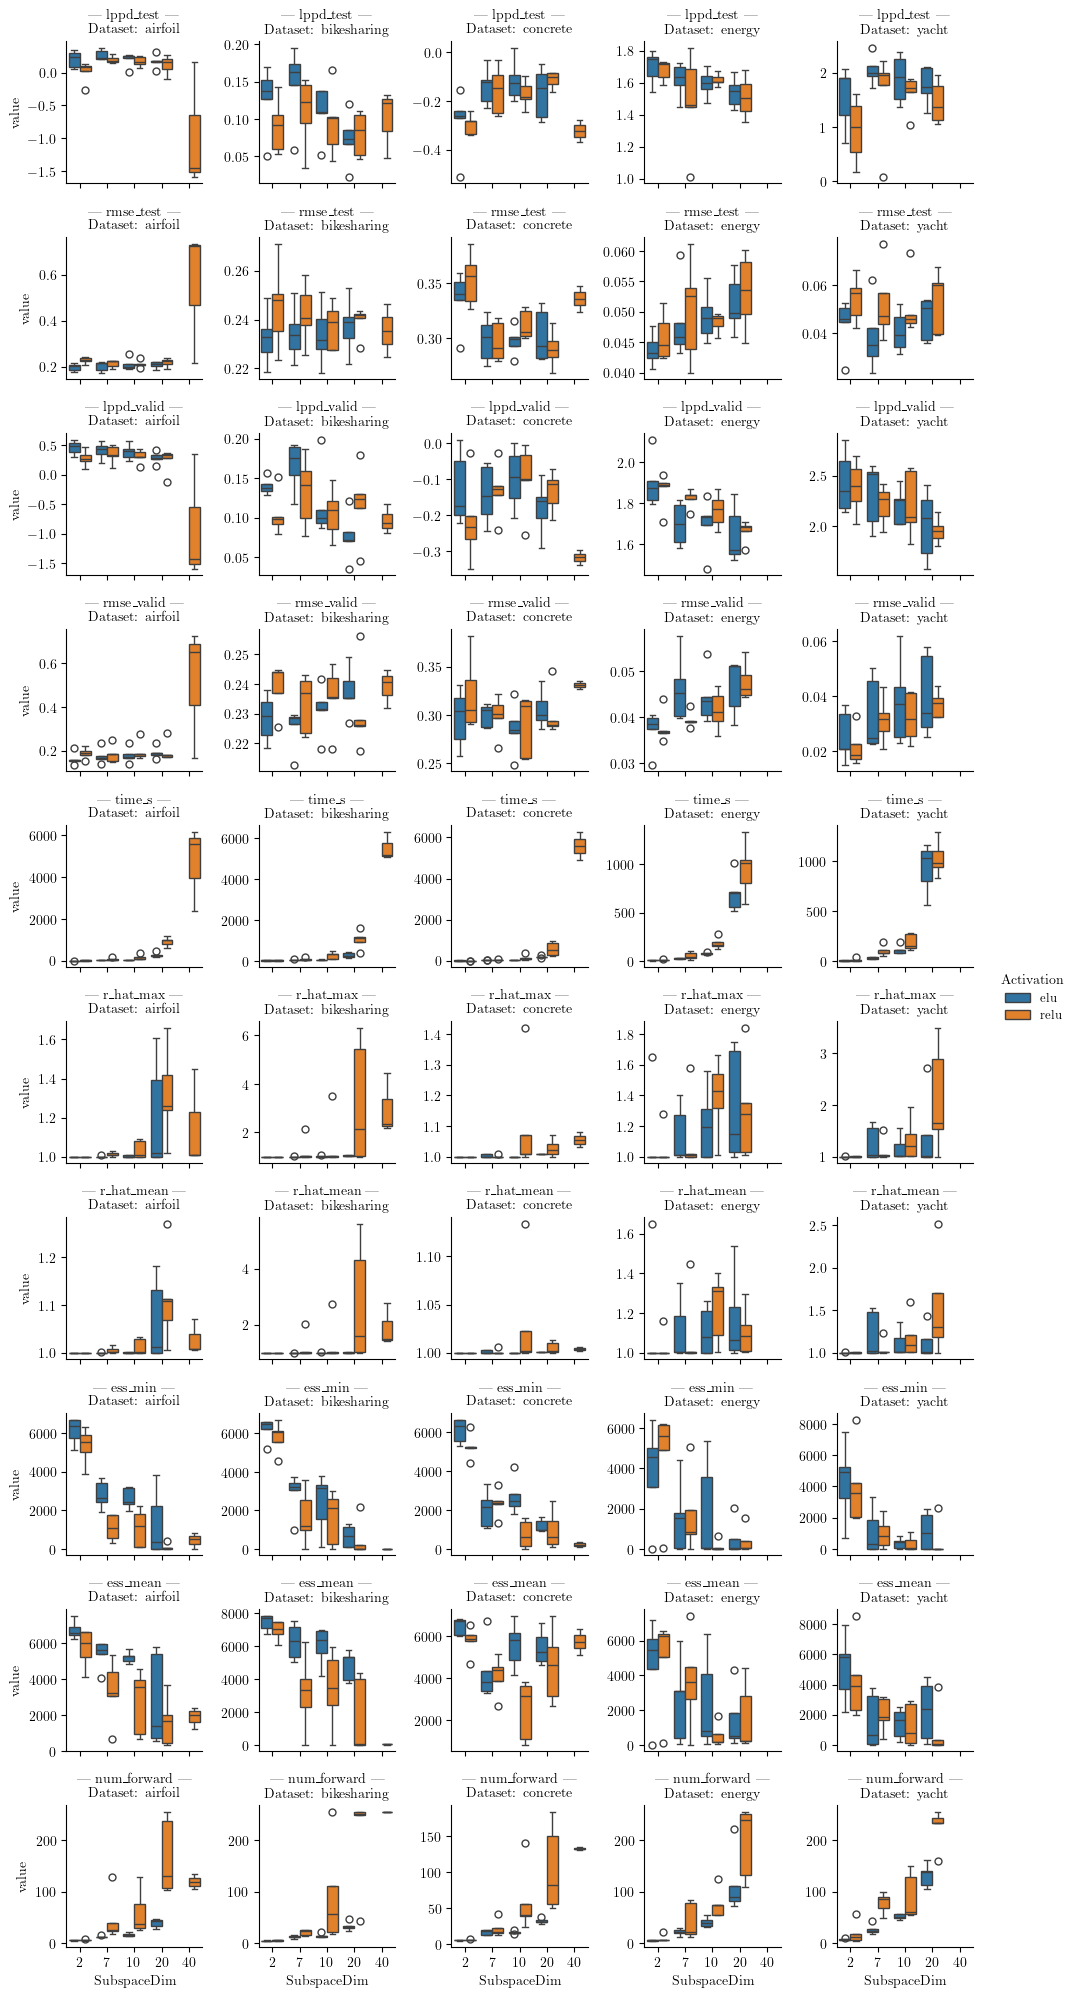

In [11]:
df_subset = df_best_t[df_best_t['Space'] == 'lambda']
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)

g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
                col='Dataset', row='metric', kind='box', hue='Activation', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
g.tight_layout()

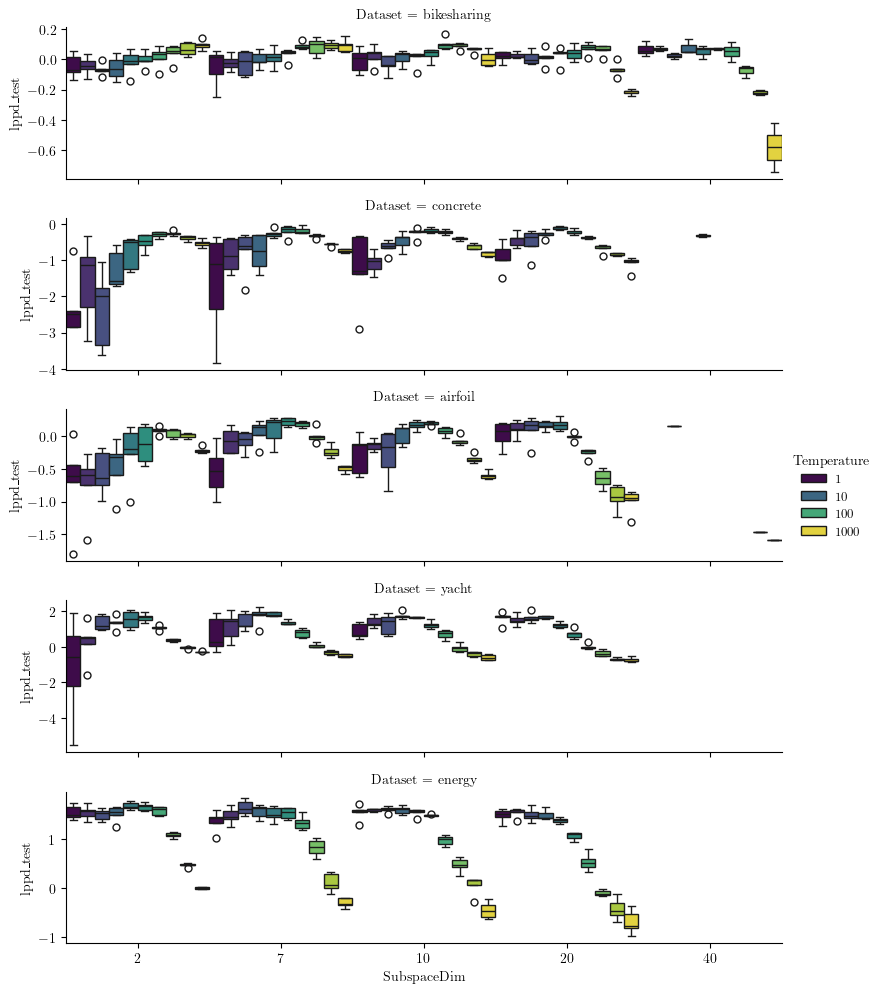

In [46]:
from matplotlib import colors

df_subset = df_clean[(df_clean['Activation'] == 'relu') & (df_clean['Space'] == 'lambda')]
df_best_t_sub = df_best_t[(df_best_t['Activation'] == 'relu')
                         & (df_best_t['Space'] == 'lambda')]
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                row='Dataset', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))

# g.map_dataframe(sns.boxplot, data=df_best_t_sub, y='lppd_test', x='SubspaceDim', width=.1, color='red')
# g.axes[0, 0].set_ylim(-5, )
# Add the new plot to the existing FacetGrid
# for ax in g.axes.flat:
#     sns.boxplot(data=df_best_t_sub, y='lppd_test',
#                 x='SubspaceDim', ax=ax, color='red', width=.1)
#     ax.set_ylabel('lppd_test')  # Ensure the y-axis label is consistent

g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

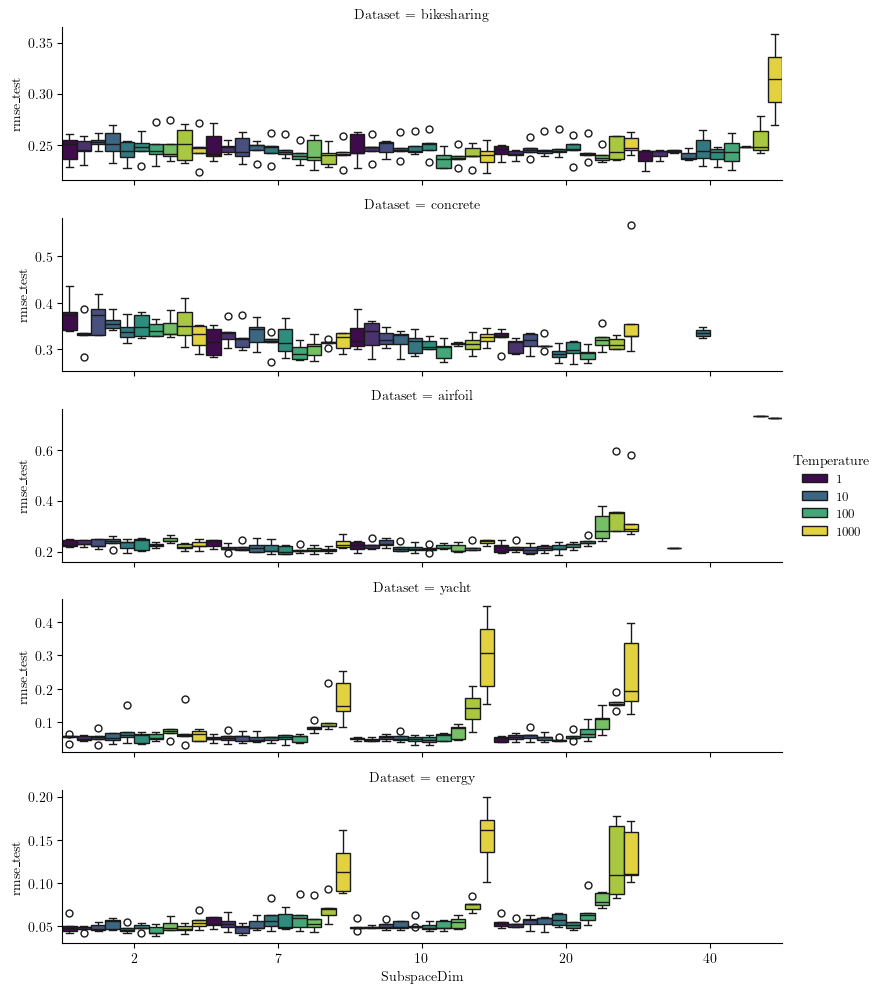

In [13]:
from matplotlib import colors
# df_subset = df_best_t
vmin = df_subset['Temperature'].min()
vmax = df_subset['Temperature'].max()
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                row='Dataset', kind='box', hue='Temperature', sharey=False, height=figsize[1], aspect=4, palette='viridis', width=1., hue_norm=colors.LogNorm(vmin=vmin, vmax=vmax))
# g.axes[0, 0].set_ylim(-5, )
g.savefig('figures/uci_all_T_lppd_test.pdf', bbox_inches='tight')

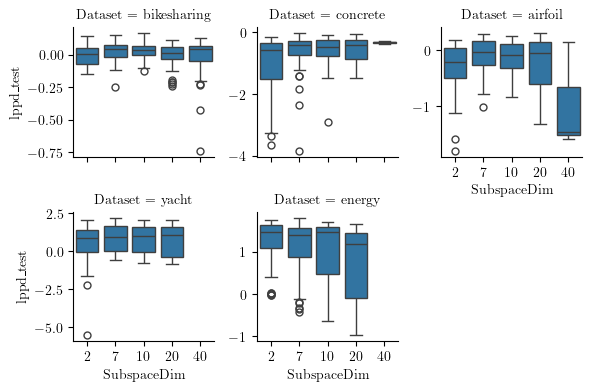

In [15]:
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Activation', sharey=False, height=figsize[1], legend=False, col_wrap=3)
# g.axes[0, 0].set_ylim(-5, )
g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

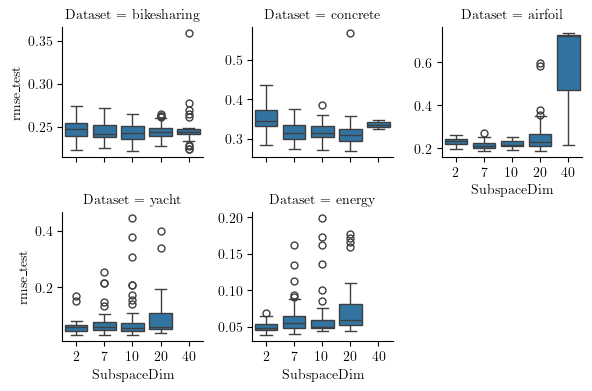

In [16]:
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Activation', sharey=False, height=figsize[1], legend=False, col_wrap=3)

g.savefig('figures/uci_best_t_rmse_test.pdf', bbox_inches='tight')

In [23]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu')]
df_subset = df_subset.loc[:, ['Dataset', 'Space',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'Space', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(2).astype(
        str) + " ± " + x['rmse_test_std'].round(2).astype(str),
    lppd_test=lambda x: x['lppd_test_mean'].round(2).astype(
        str) + " ± " + x['lppd_test_std'].round(2).astype(str)
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])

rmse_test     lppd_test
Dataset     Space  SubspaceDim                           
airfoil     lambda 2            0.23 ± 0.01   0.01 ± 0.16
                   7            0.21 ± 0.02    0.2 ± 0.06
                   10           0.21 ± 0.02   0.17 ± 0.08
                   20           0.22 ± 0.02   0.12 ± 0.14
                   40            0.56 ± 0.3  -0.96 ± 0.97
            line   2            0.23 ± 0.02    0.04 ± 0.2
                   7             0.2 ± 0.01   0.22 ± 0.06
                   10           0.21 ± 0.01   0.22 ± 0.04
bikesharing lambda 2            0.25 ± 0.02   0.09 ± 0.04
                   7            0.24 ± 0.01   0.11 ± 0.05
                   10           0.24 ± 0.01    0.1 ± 0.05
                   20           0.24 ± 0.01   0.08 ± 0.03
                   40           0.24 ± 0.01    0.1 ± 0.05
            line   2            0.25 ± 0.01   0.09 ± 0.02
                   7            0.24 ± 0.01   0.13 ± 0.03
                   10           0.24 ± 0.01   0.12 ± 0.04
concrete    lambda 2            0.35 ± 0.02   -0.3 ± 0.04
                   7             0.3 ± 0.02   -0.16 ± 0.1
                   10           0.31 ± 0.01  -0.17 ± 0.06
                   20           0.29 ± 0.02  -0.11 ± 0.03
                   40           0.34 ± 0.02  -0.32 ± 0.07
            line   2            0.34 ± 0.02   -0.29 ± 0.1
                   7             0.3 ± 0.02  -0.11 ± 0.05
                   10            0.3 ± 0.01  -0.13 ± 0.05
energy      lambda 2             0.05 ± 0.0   1.68 ± 0.06
                   7            0.05 ± 0.01   1.49 ± 0.31
                   10            0.05 ± 0.0   1.62 ± 0.04
                   20           0.05 ± 0.01   1.51 ± 0.13
            line   2             0.05 ± 0.0   1.61 ± 0.11
                   7            0.05 ± 0.01   1.62 ± 0.13
                   10            0.05 ± nan    1.46 ± nan
yacht       lambda 2            0.05 ± 0.01    0.94 ± 0.6
                   7            0.05 ± 0.02   1.61 ± 0.87
                   10           0.05 ± 0.01   1.63 ± 0.35
                   20           0.05 ± 0.01    1.45 ± 0.4
            line   2            0.07 ± 0.04   0.41 ± 1.54
                   7            0.06 ± 0.02    1.13 ± 1.0

In [57]:
df_subset = df_best_t[(df_best_t['Activation'] == 'relu')]
df_subset = df_subset.loc[:, ['Dataset',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(3).astype(
        str) + " ± " + x['rmse_test_std'].round(3).astype(str),
    lppd_test=lambda x: x['lppd_test_mean'].round(3).astype(
        str) + " ± " + x['lppd_test_std'].round(3).astype(str)
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])

rmse_test       lppd_test
Dataset     SubspaceDim                               
airfoil     2            0.228 ± 0.013   0.014 ± 0.162
            7            0.213 ± 0.016   0.195 ± 0.056
            10           0.211 ± 0.016   0.167 ± 0.075
            20           0.218 ± 0.018   0.121 ± 0.143
            40             0.215 ± nan     0.155 ± nan
bikesharing 2            0.246 ± 0.018   0.091 ± 0.036
            7            0.242 ± 0.012    0.11 ± 0.048
            10            0.237 ± 0.01   0.096 ± 0.047
            20           0.239 ± 0.006     0.08 ± 0.03
            40             0.261 ± nan    -0.016 ± nan
concrete    2            0.353 ± 0.024  -0.296 ± 0.041
            7            0.297 ± 0.018  -0.157 ± 0.099
            10           0.312 ± 0.013  -0.172 ± 0.055
            20           0.291 ± 0.017  -0.113 ± 0.033
energy      2            0.046 ± 0.004   1.678 ± 0.064
            7             0.05 ± 0.008   1.485 ± 0.307
            10           0.048 ± 0.002   1.616 ± 0.039
            20           0.053 ± 0.006   1.511 ± 0.128
yacht       2             0.054 ± 0.01   0.938 ± 0.598
            7            0.052 ± 0.016   1.607 ± 0.868
            10           0.051 ± 0.013   1.626 ± 0.346
            20           0.053 ± 0.013    1.45 ± 0.396

#### with specific temperature

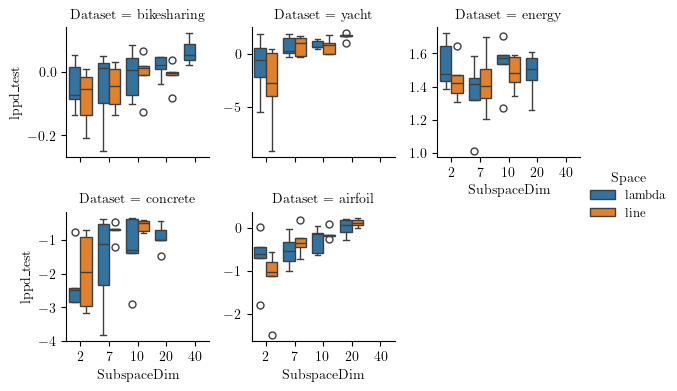

In [24]:
df_subset = df_clean[(df_clean['Activation'] == 'relu') & (df_clean['Temperature'] == 1.)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Space', sharey=False, height=figsize[1], legend=True, col_wrap=3)
# g.axes[0, 0].set_ylim(-5, )
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')b


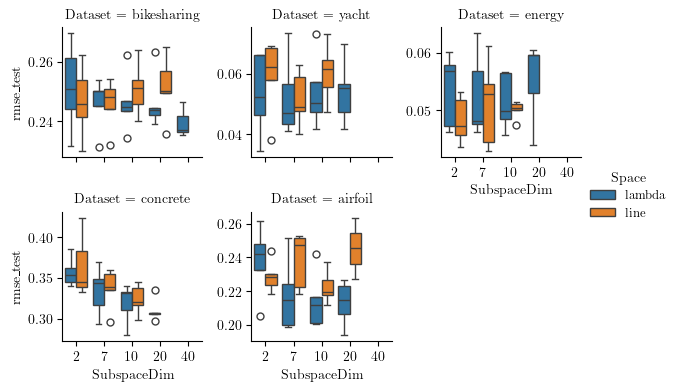

In [27]:
df_subset = df_clean[(df_clean['Activation'] == 'relu')
                     & (df_clean['Temperature'] == 10.)]
# df_subset = df_best_t
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Space', sharey=False, height=figsize[1], legend=True, col_wrap=3)
# g.axes[0, 0].set_ylim(-5, )
# g.savefig('figures/uci_best_t_lppd_test.pdf', bbox_inches='tight')

#### old?

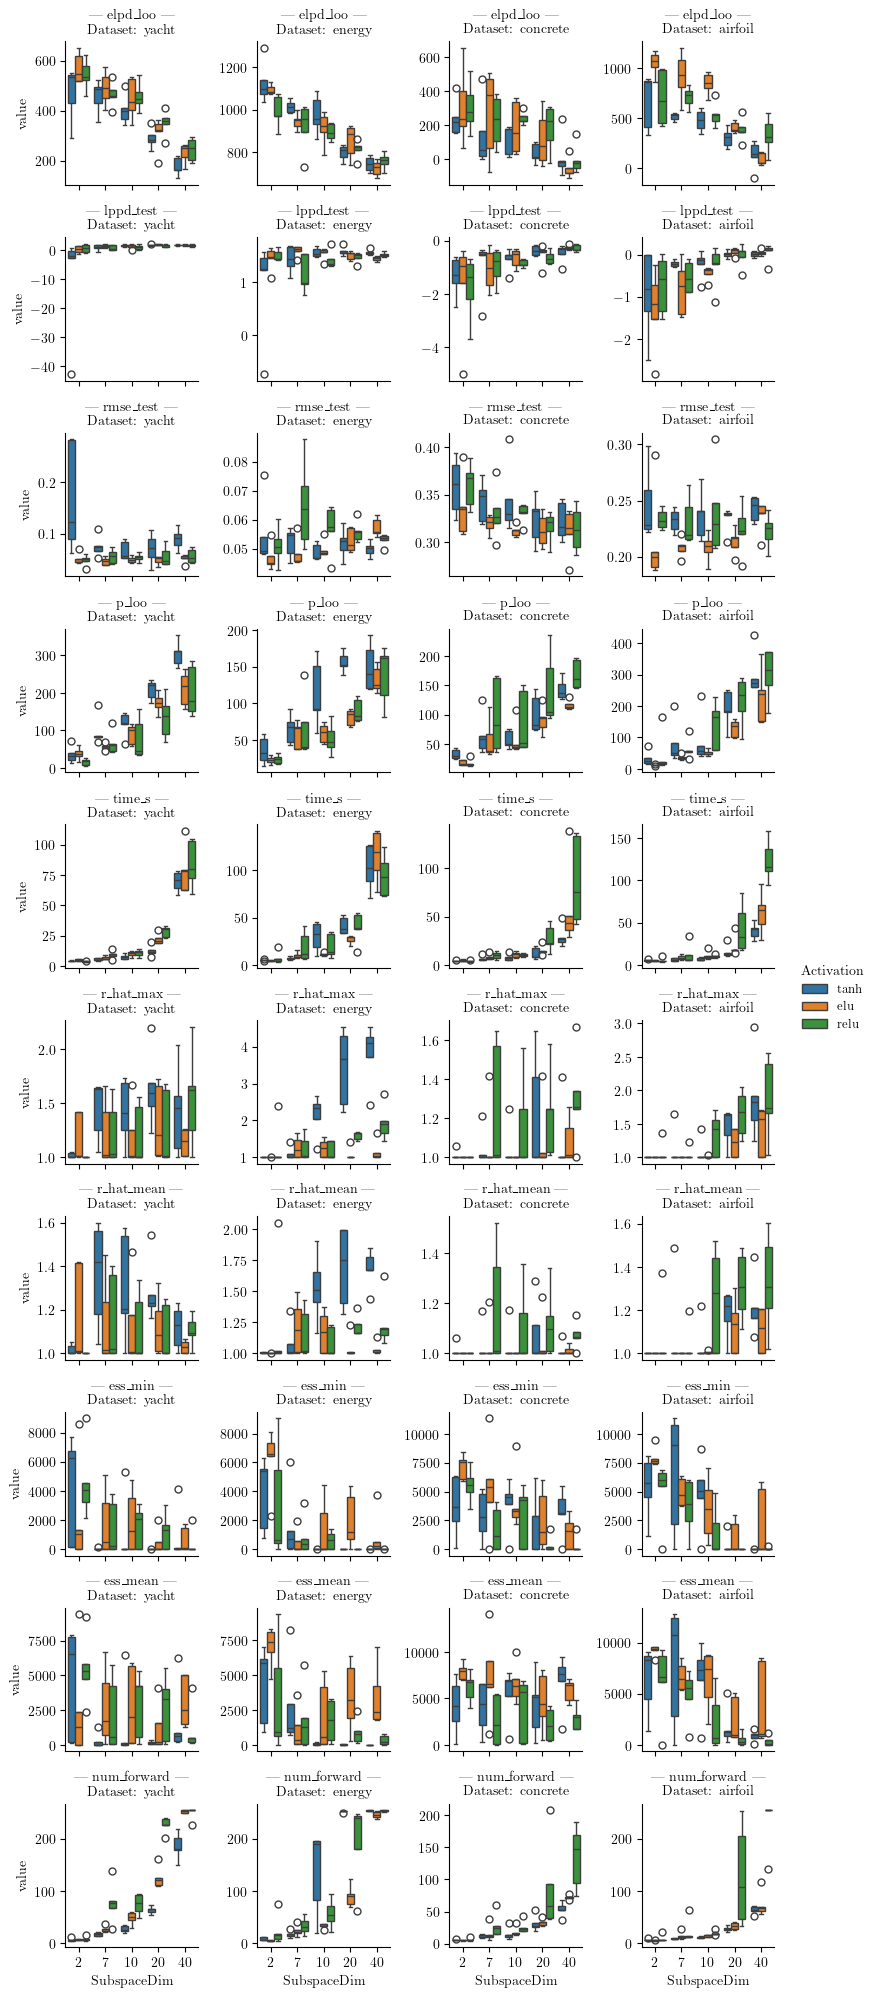

In [10]:
# check Tube scale
df_subset = df_clean[df_clean['SelectFromValidation'] == True]
df_subset = df_subset.set_index(idx_ids)
df_melt = df_subset.melt(
    var_name='metric', value_name='value', ignore_index=False)

g = sns.catplot(data=df_melt.reset_index(), y='value', x='SubspaceDim',
            col='Dataset', row='metric', kind='box', hue='Activation', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
g.tight_layout()

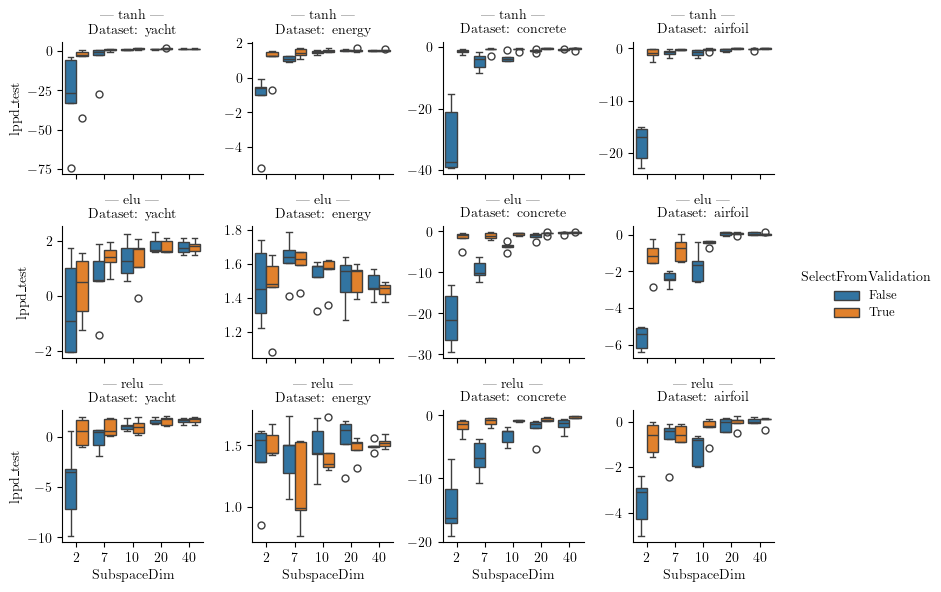

In [12]:
g = sns.catplot(data=df_clean, y='lppd_test', x='SubspaceDim',
                col='Dataset', row='Activation', kind='box', hue='SelectFromValidation', sharey=False, height=figsize[1])
g.set_titles(row_template='--- {row_name}',
             col_template='\nDataset: {col_name}')
g.tight_layout()

(-5.0, 4.500173091888428)

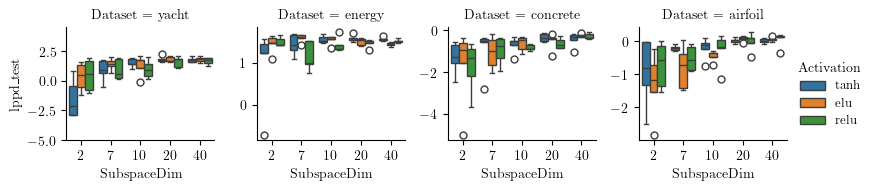

In [13]:
df_subset = df_clean[df_clean['SelectFromValidation'] == True]
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', kind='box', hue='Activation', sharey=False, height=figsize[1])
g.axes[0,0].set_ylim(-5, )

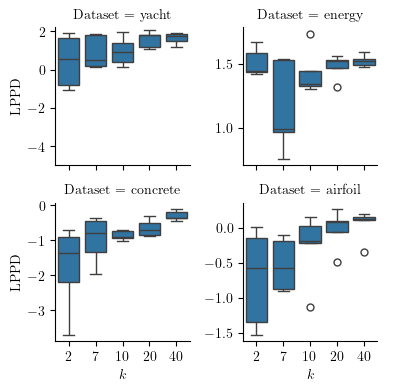

In [14]:
df_subset = df_clean[(df_clean['SelectFromValidation'] == True) & (df_clean['Activation'] == 'relu')]
g = sns.catplot(data=df_subset, y='lppd_test', x='SubspaceDim',
                col='Dataset', kind='box', sharey=False, height=figsize[1], col_wrap=2)
g.axes[0].set_ylim(-5, )
g.set_ylabels('LPPD')
g.set_xlabels(r'$k$')
g.tight_layout()

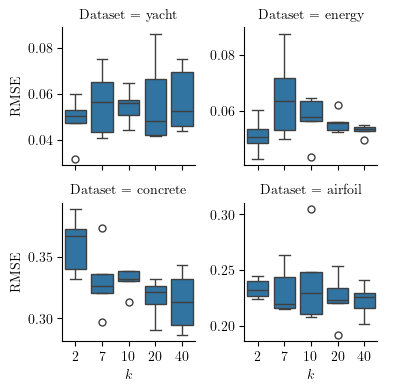

In [15]:
df_subset = df_clean[(df_clean['SelectFromValidation'] ==
                      True) & (df_clean['Activation'] == 'relu')]
g = sns.catplot(data=df_subset, y='rmse_test', x='SubspaceDim',
                col='Dataset', kind='box', sharey=False, height=figsize[1], col_wrap=2)
# g.axes[0, 0].set_ylim(-5, )
g.set_ylabels('RMSE')
g.set_xlabels(r'$k$')
g.tight_layout()

In [16]:
df_subset = df_clean[(df_clean['SelectFromValidation'] == True) & (
    df_clean['Activation'] == 'relu')]
df_subset = df_subset.loc[:, ['Dataset', 'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'SubspaceDim']).agg(
    rmse_test_mean=('rmse_test', 'mean'),
    rmse_test_std=('rmse_test', 'std'),
    lppd_test_mean=('lppd_test', 'mean'),
    lppd_test_std=('lppd_test', 'std')
).assign(
    rmse_test=lambda x: x['rmse_test_mean'].round(3).astype(str) + " ± " + x['rmse_test_std'].round(3).astype(str),
    lppd_test=lambda x: x['lppd_test_mean'].round(3).astype(str) + " ± " + x['lppd_test_std'].round(3).astype(str)
).drop(columns=['rmse_test_mean', 'rmse_test_std', 'lppd_test_mean', 'lppd_test_std'])

rmse_test       lppd_test
Dataset  SubspaceDim                               
airfoil  2            0.233 ± 0.009  -0.718 ± 0.693
         7            0.231 ± 0.022   -0.531 ± 0.37
         10            0.24 ± 0.039  -0.276 ± 0.505
         20           0.225 ± 0.023  -0.022 ± 0.286
         40           0.223 ± 0.015   0.043 ± 0.223
concrete 2             0.36 ± 0.023  -1.762 ± 1.223
         7            0.331 ± 0.028  -0.971 ± 0.668
         10            0.331 ± 0.01   -0.852 ± 0.14
         20           0.316 ± 0.016  -0.639 ± 0.246
         40           0.314 ± 0.024   -0.293 ± 0.14
energy   2            0.051 ± 0.006    1.511 ± 0.11
         7            0.065 ± 0.015   1.157 ± 0.354
         10           0.057 ± 0.008   1.429 ± 0.178
         20           0.056 ± 0.004   1.479 ± 0.097
         40           0.053 ± 0.002   1.522 ± 0.045
yacht    2             0.048 ± 0.01   0.467 ± 1.367
         7            0.056 ± 0.015   0.903 ± 0.864
         10           0.054 ± 0.008   0.973 ± 0.743
         20           0.057 ± 0.019   1.586 ± 0.437
         40           0.057 ± 0.014     1.655 ± 0.3

In [62]:
df_subset = df_clean[(df_clean['SelectFromValidation'] == False) & (
    df_clean['Activation'] == 'relu')]
df_subset = df_subset.loc[:, ['Dataset',
                              'SubspaceDim', 'rmse_test', 'lppd_test']]
df_subset.groupby(['Dataset', 'SubspaceDim']).mean()

rmse_test  lppd_test
Dataset  SubspaceDim                      
airfoil  2             0.262669  -3.544599
         7             0.225771  -0.788596
         10            0.238208  -1.210002
         20            0.219604  -0.112146
         40            0.214602   0.055274
concrete 2             0.422725 -14.233017
         7             0.360923  -6.756486
         10            0.336743  -3.243071
         20            0.333324  -2.134759
         40            0.345367  -1.495524
energy   2             0.047373   1.394279
         7             0.056301   1.414521
         10            0.052318   1.479038
         20            0.051691   1.550493
         40            0.054204   1.494258
yacht    2             0.072966  -4.645253
         7             0.070468  -0.186340
         10            0.058306   1.084151
         20            0.059262   1.530406
         40            0.057126   1.610478

### Load data

In [33]:
dataset_name = "airfoil"
# dataset_name = "airfoil"
# dataset_name = "bikesharing"
val_size = 0.1
test_size = 0.1
dataconfig = DataConfig(
    path=f'{os.getcwd()}/proba_sandbox/data/{dataset_name}.data',
    source=f'local',
    data_type='tabular',
    task='regr',
    target_column=None,
    features=None,
    datapoint_limit=None,
    normalize=True,
    train_split=0.7,
    valid_split=0.1,
    test_split=0.2,
)

rng_key = random.PRNGKey(1)
data = TabularLoader(config=dataconfig, rng=rng_key)
print(f"""Train shape: x {data.train_x.shape} y{data.train_y.shape}
Val shape:   x {data.valid_x.shape}  y{data.valid_y.shape}
Test shape:  x {data.test_x.shape}  y{data.test_y.shape}""") 

Train shape: x (1127, 5) y(1127,)
Val shape:   x (75, 5)  y(75,)
Test shape:  x (301, 5)  y(301,)


In [34]:
# jnp.savez(f"test_airfoil_julius.npz", y_val=data.valid_y, y_test=data.test_y)
data.valid_y

Array([ 1.3372359 , -0.10874417,  0.3583139 ,  0.3216281 ,  0.0469909 ,
       -0.7335662 ,  0.9650104 ,  1.2534232 ,  0.842192  ,  0.646148  ,
       -1.8672078 ,  0.6763078 ,  0.8790227 ,  0.08193648, -1.2593507 ,
       -0.56318605,  1.7386079 ,  0.83421785, -1.8367571 ,  0.3571545 ,
       -0.3865719 ,  0.45111635, -2.545102  , -1.1764086 ,  0.92078525,
       -1.674497  , -1.2705165 ,  0.61149013,  0.55204016,  0.9869062 ,
        0.4944731 , -0.9905138 ,  0.60917133,  0.64455277, -0.443848  ,
        0.34946907, -0.35684583, -2.350651  ,  0.7024075 ,  0.2433258 ,
       -1.7828153 ,  1.3447764 , -2.0020616 ,  1.2138379 , -1.0995567 ,
        1.0753587 , -0.465309  , -1.7052387 ,  0.5231836 ,  0.729089  ,
        0.2778366 , -0.60639787,  1.3363664 ,  0.5038987 ,  0.08933204,
        0.17183937,  0.42298555,  0.52071875,  1.0338882 , -0.8301389 ,
       -1.2967622 ,  0.6860233 , -0.20937699, -0.25302246,  1.4976108 ,
        2.341969  , -0.6237987 , -2.1067545 , -0.09395303, -1.72

In [35]:
jnp.savez(f"test_airfoil_julius_seed_1.npz", x_train = data.train_x,   y_train = data.train_y, 
                                      x_val = data.valid_x,       y_val = data.valid_y, 
                                      x_test = data.test_x,     y_test = data.test_y)
data.valid_y

Array([ 1.3372359 , -0.10874417,  0.3583139 ,  0.3216281 ,  0.0469909 ,
       -0.7335662 ,  0.9650104 ,  1.2534232 ,  0.842192  ,  0.646148  ,
       -1.8672078 ,  0.6763078 ,  0.8790227 ,  0.08193648, -1.2593507 ,
       -0.56318605,  1.7386079 ,  0.83421785, -1.8367571 ,  0.3571545 ,
       -0.3865719 ,  0.45111635, -2.545102  , -1.1764086 ,  0.92078525,
       -1.674497  , -1.2705165 ,  0.61149013,  0.55204016,  0.9869062 ,
        0.4944731 , -0.9905138 ,  0.60917133,  0.64455277, -0.443848  ,
        0.34946907, -0.35684583, -2.350651  ,  0.7024075 ,  0.2433258 ,
       -1.7828153 ,  1.3447764 , -2.0020616 ,  1.2138379 , -1.0995567 ,
        1.0753587 , -0.465309  , -1.7052387 ,  0.5231836 ,  0.729089  ,
        0.2778366 , -0.60639787,  1.3363664 ,  0.5038987 ,  0.08933204,
        0.17183937,  0.42298555,  0.52071875,  1.0338882 , -0.8301389 ,
       -1.2967622 ,  0.6860233 , -0.20937699, -0.25302246,  1.4976108 ,
        2.341969  , -0.6237987 , -2.1067545 , -0.09395303, -1.72

In [17]:
config = {
        'curve_params': {'k': 2,
                         'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'relu'},
                         'n_samples': 10,
                         'lr': 0.005,
                         'out_scale': 0.05,
                         'optimize_distparams': True,
                         'num_epochs': 1_000},
        'sampling': {'space_config': {'space': 'lambda', 
                                      'prior_scale': .5,
                                      'tube_scale': 1.,
                                      'prior_correct': False,
                                      'epsilon': 25.},
                     'num_chains': 10,
                     'temperature': 1.,
                     'num_warmup': 1000,
                     'num_draws': 1000,
                     'sampler': 'mclmc'},
        'rng_seed': 0
    }

### train curve model

  0%|          | 0/1000 [00:00<?, ?it/s]

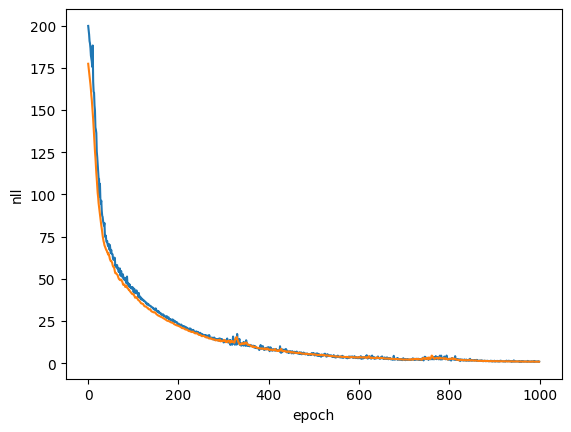

In [4]:
# logger = wandb.init(project="subspace_test", config=config)



k = config['curve_params']['k']
rng_key = random.PRNGKey(config['rng_seed'])
rng_key, init_key = random.split(rng_key)
model = MLPModel(**config['curve_params']['model_kwargs'])
s_model = SubspaceModel(
    model, k, 
    n_samples=config['curve_params']['n_samples'],
    out_scale=config['curve_params']['out_scale'],
    optimize_distparams=config['curve_params']['optimize_distparams'])
params = s_model.init_params(init_key, data.train_x)

# Train
lr = config['curve_params']['lr']
optimizer = optax.adam(lr)
if config['curve_params']['optimize_distparams']:
    opt_state = optimizer.init(params)
else:
    opt_state = optimizer.init(params['params'])
losses = []
valid_losses = []
best_loss = np.inf
best_params = params


@scan_tqdm(config['curve_params']['num_epochs'])
def train(carry, _):
    rng_key, params, opt_state, best_loss, best_params = carry
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(
        subkey, params, data.train_x, data.train_y, opt_state, optimizer)
    # validate
    rng_key, subkey = random.split(rng_key)
    val_loss = s_model.compute_loss(
        subkey, params, data.valid_x, data.valid_y, n_samples=1000)
    best_params = jax.lax.cond(val_loss < best_loss, lambda x: params, lambda x: best_params, None)
    best_loss = jnp.minimum(best_loss, val_loss)
    return (rng_key, params, opt_state, best_loss, best_params), (loss, val_loss)

carry = (rng_key, params, opt_state, best_loss, best_params)
carry, (losses, valid_losses) = jax.lax.scan(train, carry, jnp.arange(config['curve_params']['num_epochs']))

# [logger.log({"loss": l, "valid_loss": vl}) for l, vl in zip(losses, valid_losses)]

params = carry[1]
best_loss = carry[3]
best_params = carry[4]

plt.plot(losses)
plt.plot(valid_losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()
# wandb.finish()

In [15]:
np.log(0.05)

-2.995732273553991

In [16]:
params

{'dist_params': {'log_scale': Array(-2.026516, dtype=float32)},
 'params': {'Dense_0': {'bias': Array([[ 1.49282873e-01, -2.43188843e-01, -2.60308564e-01,
           -5.96901588e-02,  6.43415004e-02,  2.29531582e-02,
            1.93351418e-01, -2.03263406e-02, -1.13400973e-01,
            1.10883489e-01,  2.66709536e-01, -5.92222288e-02,
            2.30198950e-01, -6.73091635e-02,  9.94009003e-02,
           -1.60388499e-01],
          [ 2.10822806e-01, -3.11401784e-01, -1.51751876e-01,
           -9.22340304e-02,  1.10546239e-01,  1.22040384e-01,
            2.67027169e-01, -7.29748532e-02, -1.09924763e-01,
            3.23554315e-02,  3.31434071e-01, -1.89695626e-01,
            2.04960123e-01,  9.22522396e-02,  4.28161509e-02,
           -9.05635282e-02],
          [ 2.14257911e-01, -3.39285702e-01, -1.14890203e-01,
           -1.36765674e-01,  1.44863665e-01,  7.93070421e-02,
            3.16998899e-01, -1.41309753e-01, -1.23792954e-01,
            2.34709270e-02,  1.73918843e-01

In [17]:
# k = config['curve_params']['k']
# rng_key = random.PRNGKey(config['rng_seed'])
# rng_key, init_key = random.split(rng_key)
# model = MLPModel(**config['curve_params']['model_kwargs'])
# s_model = SubspaceModel(
#     model, k, n_samples=config['curve_params']['n_samples'])
# params = s_model.init_params(init_key, data.train_x)

# # Train
# lr = config['curve_params']['lr']
# optimizer = optax.adam(lr)
# opt_state = optimizer.init(params)

# losses = []
# valid_losses = []
# best_loss = np.inf
# best_params = params
# for i in tqdm(range(config['curve_params']['num_epochs'])):
#     rng_key, subkey = random.split(rng_key)
#     loss, params, opt_state = s_model.train_step(
#         subkey, params, data.train_x, data.train_y, opt_state, optimizer)
#     losses.append(loss)
#     rng_key, subkey = random.split(rng_key)
#     val_loss = s_model.compute_loss(
#         subkey, params, data.valid_x, data.valid_y, n_samples=1000)
#     if val_loss < best_loss:
#         best_loss = val_loss
#         best_params = params
#     valid_losses.append(val_loss)

# plt.plot(losses)
# plt.plot(valid_losses)
# plt.ylabel("nll")
# plt.xlabel("epoch")
# plt.show()

Text(0.5, 0, 'epoch')

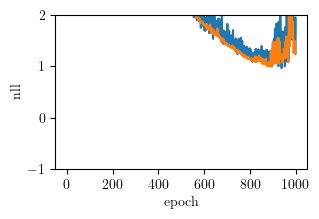

In [18]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses))
plt.plot(jnp.array(valid_losses))
plt.ylim(-1, 2)
plt.ylabel("nll")
plt.xlabel("epoch")

best loss: -1.0912656784057617


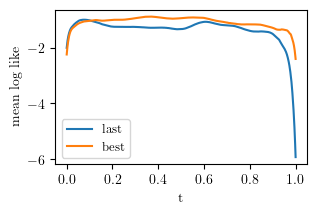

In [19]:
t_space = jnp.linspace(0.0, 1.0, 1000)

nll = s_model.nll(params, t_space, data.train_x, data.train_y).mean(axis=-1)
plt.plot(t_space, -nll, label="last")
nll = s_model.nll(best_params, t_space, data.train_x, data.train_y).mean(axis=-1)
plt.plot(t_space, -nll, label="best")
print(f"best loss: {-nll.mean()}")
plt.xlabel("t")
plt.ylabel("mean log like")
plt.legend()

## sample Model

### construct subspace

In [5]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(best_params['params'], k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")


Control points in phi space: (41, 40)


space_at_t0 shape (40, 40)
Stores 60 orthogonal frames  
with ortho frame shape (60, 40, 40)


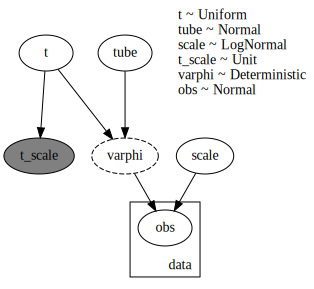

In [6]:
t_lambda_to_phi, curve, d_bezier = init_t_lambda_to_phi(cp_phi, 
                                       k, 
                                       epsilon=config['sampling']['space_config']['epsilon'], 
                                       tube_scale=config['sampling']['space_config']['tube_scale'])

tt = jnp.linspace(0., 1., 10_000)
bezier_grad = jax.vmap(d_bezier)(tt)
log_normalized_bezier_grad = jnp.log(jnp.trapezoid(
        jnp.linalg.norm(bezier_grad, axis=-1), tt))

model_tube = init_model_tube(model,
                             params['params'],
                             k,
                             t_lambda_to_phi,
                             t_phi_to_weight,
                             prior_correct=config['sampling']['space_config']['prior_correct'],
                             prior_scale=config['sampling']['space_config']['prior_scale'],
                             d_bezier=d_bezier,
                             log_norm_d_bezier=log_normalized_bezier_grad,
                            #  dist_scale=jnp.exp(best_params['dist_params']['log_scale']).item())
                             dist_scale="homo" if config['curve_params']['optimize_distparams'] else jnp.exp(best_params['dist_params']['log_scale']).item())


# Example usage:
numpyro.render_model(model_tube, model_args=(
    data.train_x,), render_distributions=True)

In [39]:
# print format shapes
with handlers.seed(rng_seed=0):
    traced = handlers.trace(model_tube).get_trace(data.train_x)
print(numpyro.util.format_shapes(traced))

Trace Shapes:           
 Param Sites:           
Sample Sites:           
       t dist       |  1
        value       |  1
    tube dist       | 39
        value       | 39
   scale dist       |   
        value       |   
 t_scale dist       |  0
        value       |  0
   data plate 13034 |   
     obs dist 13034 |   
        value 13034 |   


### run sampling

In [7]:
num_chains = config['sampling']['num_chains']
temperature = config['sampling']['temperature']
n_samples_nuts = 2
num_warmup = config['sampling']['num_warmup'] * n_samples_nuts//2
num_draws = config['sampling']['num_draws'] * n_samples_nuts//2
USE_PMAP = False

rng_key = random.PRNGKey(1)

def warmup_fn(rng_key, initial_position, init_fn, num_warmup=num_warmup):
    # run warmup adaption
    rng_key, warmup_key = jax.random.split(rng_key)
    warmup_key = jax.random.split(warmup_key, num_chains)

    time_start = time.time()
    
    if USE_PMAP:
        run = jax.pmap(init_fn, in_axes=(None, 0, 0), static_broadcasted_argnums=(0,), devices=jax.devices('cpu'))
    else:
        run = jax.vmap(init_fn, in_axes=(None, 0,0))
    last_state, parameters = run(num_warmup, warmup_key, initial_position)
    jax.block_until_ready(last_state)
    time_ = time.time() - time_start
    return time_, rng_key, last_state, parameters


def run_inference(kernel, rng_key, last_state, parameters, num_samples=num_draws):
    rng_key, sample_key = jax.random.split(rng_key)
    sample_keys = jax.random.split(sample_key, num_chains)

    def inference_loop(rng_key, parameters, initial_state, num_samples):
        final_state, trace_state, trace_info = blackjax.util.run_inference_algorithm(
            rng_key=rng_key,
            initial_state=initial_state,
            inference_algorithm=kernel(parameters),
            num_steps=num_samples,
            # transform=transform,
            progress_bar=False,
        )
        return trace_state, trace_info

    # run inference loop
    if USE_PMAP:
        inference_loop_multiple_chains = jax.pmap(inference_loop, 
                                                  in_axes=(0, 0, 0, None), 
                                                  static_broadcasted_argnums=(3,), 
                                                  devices=jax.devices('cpu'))
    else:
        inference_loop_multiple_chains = jax.vmap(inference_loop, in_axes=(
            0, 0, 0, None))

    # jax.debug.print(f"params: {parameters['max_num_doublings']}")
    time_start = time.time()
    pmap_states, pmap_infos = inference_loop_multiple_chains(
        sample_keys, parameters, last_state, num_draws)
    jax.block_until_ready(pmap_states)
    time_ = time.time() - time_start
    return time_, rng_key, pmap_states, pmap_infos

# start with sampling -> generate potential_fn for blackjax
rng_key, init_key = jax.random.split(rng_key)
init_params, potential_fn, post_proc_fun, _ = initialize_model(
    init_key,
    # model_tube,
    model_tube,
    model_args=(data.train_x, data.train_y, temperature),
    # could also set to True => potential_fn_gen(**model_args) instead of potential_fn
    dynamic_args=False,
)

def logdensity_fn(params):
    return -potential_fn(params)

### run NUTS

In [41]:
initial_position = {'t': jax.random.uniform(init_key, (num_chains, 1), minval=0., maxval=1.),
                    'tube': jnp.zeros((num_chains, k-1))}
if config['curve_params']['optimize_distparams']:
    # initial_position['scale'] = jax.random.lognormal(
    #     key=init_key, shape=((num_chains,)))
    initial_position['scale'] = jnp.full((num_chains,), jnp.exp(best_params['dist_params']['log_scale'])) + \
        (0.1 * jax.random.lognormal(init_key, shape=(num_chains,)))
with handlers.seed(rng_seed=0):
    out_init = jax.vmap(potential_fn)(initial_position)
out_init/len(data.train_x)

Array([1.1678214, 1.2762183, 1.1847454, 1.6889001, 1.1586988, 1.1965325,
       1.3630667, 1.1873798, 1.2248707, 1.1266128], dtype=float32)

In [8]:
import blackjax

In [9]:
def init_fn(num_warmup, warmup_key, initial_position):
    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=warmup_key
    )

    # build the kernel
    def kernel(sqrt_diag_cov): 
        return blackjax.mcmc.mclmc.build_kernel(
            logdensity_fn=logdensity_fn,
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
            sqrt_diag_cov=sqrt_diag_cov,
        )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_warmup,
        state=initial_state,
        rng_key=warmup_key,
        diagonal_preconditioning=False,
    )
    return blackjax_state_after_tuning, blackjax_mclmc_sampler_params

rng_key, init_key = jax.random.split(rng_key)
initial_position = {'t': jax.random.uniform(init_key, (num_chains, 1), minval=0., maxval=1.),
                    'tube': jnp.zeros((num_chains, k-1))}
if config['curve_params']['optimize_distparams']:
    # initial_position['scale'] = jax.random.lognormal(
    #     key=init_key, shape=((num_chains,)))
    initial_position['scale'] = jnp.full((num_chains,), jnp.exp(best_params['dist_params']['log_scale']))
wall_time, rng_key, last_state, parameters = warmup_fn(rng_key, initial_position, init_fn)
print("Wall time: {:.2f} s".format(wall_time))
print("MCMC parameters:", parameters)

Wall time: 27.88 s
MCMC parameters: MCLMCAdaptationState(L=Array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.5549016e-07,
       0.0000000e+00, 2.3344691e-07, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), step_size=Array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7774510e-06,
       0.0000000e+00, 1.1672346e-06, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), sqrt_diag_cov=Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.,

In [10]:
def get_kernel(parameters):
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=parameters.L,
        step_size=parameters.step_size
    )
    return sampling_alg

wall_time, rng_key, states_phi, infos_phi = run_inference(
    get_kernel, rng_key, last_state, parameters)

print("Wall time: {:.2f} s".format(wall_time))

Wall time: 43.14 s


In [11]:
selected_states = jax.tree.map(
    lambda x: x[:, ::n_samples_nuts//2], states_phi.position)

In [12]:
selected_states['tube'].shape

(10, 1000, 39)

In [13]:
posterior = jax.lax.map(lambda x: jax.vmap(post_proc_fun)(x), selected_states)

In [18]:
def log_like_fn(x, y, posterior):
    def single_log_like_fn(sample):
        with handlers.seed(rng_seed=0):
            cml = handlers.condition(model_tube, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, y, config['sampling']['temperature'])
            site = ex_trace['obs']
            log_like = site['fn'].log_prob(
                site['value'])
            return log_like
    # return jax.vmap(jax.vmap(single_log_like_fn))(posterior)
    return jax.vmap(lambda sample: jax.lax.map(single_log_like_fn, sample))(posterior)


def prediction(key, x, posterior):
    sample_keys = jax.random.split(key, num_chains)
    def single_prediction_fn(rng_key, sample):
        rng_key, sample_key = random.split(rng_key)
        with handlers.seed(rng_seed=sample_key):
            cml = handlers.condition(model_tube, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return rng_key, site['fn'].sample(sample_key)
    key, preds = jax.vmap(lambda key, sample: jax.lax.scan(
        single_prediction_fn, key, sample))(sample_keys, posterior) # vmap over chains and scan over samples
    return key[-1], preds

In [20]:
log_like = log_like_fn(data.valid_x, data.valid_y, posterior).reshape(-1, len(data.valid_y))
lppd = jnp.mean(jax.scipy.special.logsumexp(
    log_like, axis=0) - jnp.log(log_like.shape[0]))
del log_like
lppd

Array(nan, dtype=float32)

In [21]:
log_like = log_like_fn(data.test_x, data.test_y,
                       posterior).reshape(-1, len(data.test_y))
lppd = jnp.mean(jax.scipy.special.logsumexp(
    log_like, axis=0) - jnp.log(log_like.shape[0]))
del log_like
lppd

Array(nan, dtype=float32)

In [22]:
rng_key, preds = prediction(rng_key, data.valid_x, posterior)
rmse = jnp.sqrt(jnp.mean((preds.mean((0, 1)) - data.valid_y) ** 2))
del preds
rmse

Array(nan, dtype=float32)

In [23]:
rng_key, preds = prediction(rng_key, data.test_x, posterior)
rmse = jnp.sqrt(jnp.mean((preds.mean((0, 1)) - data.test_y) ** 2))
del preds
rmse

Array(nan, dtype=float32)

In [22]:
states_phi.position.keys()

dict_keys(['scale', 't', 'tube'])

In [ ]:
def compute_metrics_batched(rng_key, x, y, batch_size=300):
    n_batches = int(np.ceil(len(x) / batch_size))
    elpd = 0
    rmse = 0
    for i in range(n_batches):
        x_batch = x[i * batch_size:(i + 1) * batch_size]
        y_batch = y[i * batch_size:(i + 1) * batch_size]
        log_like_batch = log_like_fn(x_batch, y_batch, posterior).reshape(-1, len(y_batch))
        elpd += jnp.sum(jax.scipy.special.logsumexp(log_like_batch, axis=0) - jnp.log(log_like_batch.shape[0]))
        rng_key, preds = prediction(rng_key, x_batch, posterior)
        rmse += jnp.sum((preds.mean((0, 1)) - y_batch) ** 2)
    elpd /= len(x)
    rmse = jnp.sqrt(rmse / len(x))
    return rng_key, elpd, rmse

In [183]:
posterior_samples = jax.vmap(jax.vmap(post_proc_fun))(states_phi.position)
log_likelihood = jax.vmap(
    jax.vmap(log_likelihood_condition))(posterior_samples)

print("sample shapes:", states_phi.position["t"].shape)
samples_phi = az.from_dict(posterior=posterior_samples, log_likelihood={'obs':log_likelihood})
az.summary(samples_phi)

sample shapes: (10, 1000, 1)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,0.124,0.003,0.119,0.129,0.0,0.0,6135.0,5847.0,1.0
t[0],0.907,0.008,0.890,0.923,0.0,0.0,6599.0,5577.0,1.0
tube[0],-0.001,0.002,-0.005,0.003,0.0,0.0,11803.0,7686.0,1.0
varphi[0],0.595,0.014,0.569,0.622,0.0,0.0,6568.0,5505.0,1.0
varphi[1],0.136,0.015,0.104,0.162,0.0,0.0,6655.0,5321.0,1.0


In [184]:
samples_phi

Inference data with groups:
	> posterior
	> log_likelihood

In [185]:

log_likelihood_condition, predict = get_log_likelihood_condition(
    data.test_x, data.test_y)
log_likelihood = jax.vmap(jax.vmap(log_likelihood_condition))(posterior_samples)
elpd_test = jnp.mean(jax.scipy.special.logsumexp(log_likelihood, axis=0) - jnp.log(log_likelihood.shape[0]))
print("ELPD test:", elpd_test)

flatten_samples = jax.tree.map(lambda x: x.reshape(num_chains*num_draws, -1), posterior_samples)
rng_key, preds = jax.lax.scan(predict, rng_key, flatten_samples)
rmse_test = jnp.sqrt(jnp.mean((preds.mean(0) - data.test_y)**2)) 
print("RMSE test:", rmse_test)


ELPD test: -0.25848758
RMSE test: 0.21290451
